In [55]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [78]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
config_dir='./configs'
output_dir= './outputs/'
Model_dir='./Models'
dset_dir='./ProcessedData/'
TrainDataset='LC' 
TestDataset='LC'
Traverse=False

                   


In [79]:
#LC-141
#CellCycle-
#CPA-178-
#EMT-161-
#LiveCell - 157

VAE_name='VAE' 
GAN_name='GAN'

config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters

bs=1 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
#batch_size=32 # help='batch size'
image_size= 256         # Generator Image size
datatype='rgb'
nc= 3
Traverse_SaveIm=True
c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')


is_cuda = (torch.cuda.is_available() and not no_cuda)


In [80]:
VAE_chkptname='last'
GAN_chkptname='model.pt'
data_dir=os.path.join(dset_dir,TestDataset)
#out_dir = os.path.join(output_dir, name)
fvae_ckpt_path = os.path.join(Model_dir, TrainDataset, VAE_name,'chkpts',VAE_chkptname)
gan_ckpt_path = os.path.join(Model_dir, TrainDataset, GAN_name,'chkpts', GAN_chkptname)
     


In [81]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [82]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=fvae_ckpt_path
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=data_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [83]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(TestDataset, datatype, dset_dir, bs, image_size)



In [84]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(Model_dir, dataset, VAE_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path, weights_only=True)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:


    fvae_ckpt = torch.load(fvae_ckpt_path, weights_only=True)

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [85]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [86]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,
)
'''
# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)
'''

# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [87]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [88]:
# Load checkpoint if existant
it=checkpoint_io.load(os.getcwd()+gan_ckpt_path)

# Training loop


=> Loading checkpoint...


In [89]:

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

device(type='cuda', index=0)

In [91]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    if Traverse_SaveIm==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

tensor([[-0.2313, -4.8941, -5.4866, -6.1378, -3.8961, -5.5478, -5.6597, -5.6835,
         -5.3852, -4.7717]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3660, -5.8071, -6.3768, -7.0425, -4.8179, -5.8352, -6.1194, -6.3988,
         -5.8660, -5.4132]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3513, -5.5143, -6.1564, -6.7223, -4.6170, -5.6533, -5.9983, -5.9248,
         -5.7349, -5.2137]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2709, -5.0863, -5.6741, -6.2648, -4.1926, -5.5677, -5.7118, -5.6602,
         -5.5285, -4.9598]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3222, -5.6674, -6.2680, -6.8486, -4.7067, -5.7892, -6.0771, -6.1488,
         -5.8861, -5.3444]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3029, -5.3319, -5.9477, -6.5200, -4.3801, -5.6998, -5.8690, -5.9986,
         -5.6966, -5.0581]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2863, -5.1653, -5.6809, -6.3718, -4.2050, -5.6214, -5.6893, -5.8950,
 

tensor([[-0.2894, -4.8738, -5.4019, -6.2317, -3.9020, -5.4960, -5.5877, -5.7851,
         -5.3323, -4.7867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3481, -5.7884, -6.3312, -6.9667, -4.7848, -5.8430, -6.0727, -6.3595,
         -5.8853, -5.3675]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3170, -5.3460, -5.9296, -6.5106, -4.4557, -5.6418, -5.8535, -5.9042,
         -5.6675, -5.1334]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2064, -4.7545, -5.6393, -6.2233, -3.5937, -5.5051, -5.9244, -5.6404,
         -5.2759, -4.7523]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2555, -5.1631, -5.6492, -6.2853, -4.2123, -5.6718, -5.6207, -5.8739,
         -5.7331, -4.9759]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3995, -6.0059, -6.5754, -7.2481, -4.9477, -5.9222, -6.2671, -6.5729,
         -5.9217, -5.4707]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4616, -6.0975, -6.5600, -7.2436, -4.9962, -5.9830, -6.1854, -6.7003,
 

tensor([[-0.2272, -4.7297, -5.5085, -6.2928, -3.3713, -5.3908, -5.7433, -5.7037,
         -4.9197, -4.4362]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3297, -5.2553, -5.5990, -6.2501, -4.3639, -5.7848, -5.7050, -6.1032,
         -5.8305, -5.0860]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1776, -4.7565, -5.5356, -6.4700, -3.4302, -5.5112, -5.7631, -5.7433,
         -5.0858, -4.6095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2226, -4.7384, -5.4888, -6.3377, -3.3941, -5.4624, -5.7518, -5.7634,
         -4.9785, -4.5022]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2428, -4.9307, -5.5103, -6.1711, -3.9083, -5.5885, -5.7021, -5.7697,
         -5.3737, -4.7166]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2651, -5.0096, -5.5514, -6.2308, -4.0004, -5.5941, -5.6803, -5.8735,
         -5.4387, -4.7880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3377, -5.5599, -6.1515, -6.7909, -4.5493, -5.6280, -5.9508, -6.1767,
 

tensor([[-0.2103, -4.7409, -5.5378, -6.4374, -3.4145, -5.4186, -5.7386, -5.7427,
         -4.8679, -4.4573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2973, -5.0818, -5.5576, -6.2740, -4.1294, -5.6058, -5.6396, -5.8489,
         -5.4884, -4.8740]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3220, -5.3997, -5.9588, -6.6659, -4.4057, -5.7381, -5.8892, -6.0293,
         -5.6620, -5.0952]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.5387, -6.5495, -7.2068, -7.7908, -5.4432, -6.1541, -6.7344, -7.0153,
         -6.2431, -5.8303]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2500, -4.9053, -5.4710, -6.1680, -3.8504, -5.6139, -5.6771, -5.8210,
         -5.4405, -4.6991]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2404, -4.9599, -5.6050, -6.2314, -3.9604, -5.5587, -5.7338, -5.6829,
         -5.4269, -4.8033]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3768, -5.8171, -6.4532, -7.0541, -4.8562, -5.7715, -6.1503, -6.3056,
 

tensor([[-0.2793, -5.1633, -5.7742, -6.3551, -4.1862, -5.6292, -5.8538, -5.8854,
         -5.4954, -4.9035]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2602, -5.1370, -5.6950, -6.2901, -4.2309, -5.6216, -5.7333, -5.7006,
         -5.5627, -4.9309]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2914, -5.2362, -5.8341, -6.4501, -4.3205, -5.6565, -5.8317, -5.7976,
         -5.6003, -5.0518]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4161, -5.7001, -6.2253, -7.0079, -4.7159, -5.7689, -5.9444, -6.3445,
         -5.8075, -5.2991]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2539, -4.9628, -5.5097, -6.2616, -3.9309, -5.6304, -5.6860, -5.7787,
         -5.4036, -4.7867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3078, -5.0633, -5.5751, -6.2894, -4.1491, -5.4830, -5.6293, -5.7709,
         -5.4242, -4.9041]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2285, -4.7042, -5.5011, -6.3054, -3.3567, -5.3786, -5.7463, -5.6819,
 

tensor([[-0.3401, -5.5369, -6.0839, -6.7869, -4.5362, -5.7129, -5.9217, -6.1728,
         -5.6982, -5.1706]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2520, -4.9041, -5.4606, -6.1202, -3.8882, -5.7018, -5.7899, -5.8526,
         -5.4810, -4.7488]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3163, -5.3479, -5.8030, -6.4795, -4.3357, -5.7375, -5.7444, -6.0787,
         -5.6933, -5.0267]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2900, -5.2557, -5.7383, -6.4374, -4.2978, -5.7386, -5.7840, -5.9036,
         -5.5868, -5.0006]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2775, -5.0596, -5.6597, -6.2378, -4.1408, -5.6283, -5.7489, -5.6889,
         -5.5429, -4.9448]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2385, -5.0380, -5.6686, -6.2583, -4.0090, -5.6131, -5.7629, -5.7948,
         -5.5057, -4.8636]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2342, -4.8351, -5.4225, -6.1032, -3.8332, -5.6127, -5.6531, -5.6629,
 

tensor([[-0.3468, -5.7420, -6.3721, -6.9750, -4.7467, -5.8177, -6.1633, -6.2341,
         -5.8609, -5.3572]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3301, -5.5011, -5.8947, -6.5578, -4.5507, -5.9295, -5.8576, -6.2195,
         -5.9204, -5.2232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2801, -5.1811, -5.8202, -6.4572, -4.2151, -5.5784, -5.7945, -5.8026,
         -5.5408, -4.9472]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3889, -5.7827, -6.3628, -7.0491, -4.8024, -5.8295, -6.1080, -6.2808,
         -5.8745, -5.3621]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3522, -5.6447, -6.2894, -6.7951, -4.7360, -5.8095, -6.1565, -6.1129,
         -5.8951, -5.3754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3811, -5.7552, -6.4182, -7.0158, -4.8206, -5.8084, -6.1692, -6.1724,
         -5.9303, -5.4080]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2099, -4.7326, -5.5013, -6.3235, -3.3813, -5.3999, -5.7130, -5.6990,
 

tensor([[-0.7652, -6.4768, -6.9713, -7.5918, -5.2947, -5.7865, -6.3882, -7.1500,
         -5.5994, -5.5354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3619, -5.7251, -6.3256, -6.9723, -4.7391, -5.8243, -6.1011, -6.2266,
         -5.8813, -5.3416]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2239, -4.9078, -5.6710, -6.3281, -3.8106, -5.6327, -5.8948, -5.6682,
         -5.4021, -4.8278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4738, -6.4083, -7.0624, -7.7664, -5.3574, -6.1707, -6.5753, -6.8156,
         -6.2902, -5.8304]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2426, -5.1366, -5.7104, -6.2802, -4.1879, -5.6652, -5.7557, -5.6993,
         -5.5936, -4.8786]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2858, -4.9622, -5.4687, -6.2014, -4.0317, -5.5492, -5.6331, -5.7766,
         -5.4066, -4.8268]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3192, -5.4581, -6.0386, -6.6657, -4.4787, -5.7844, -5.9433, -6.0995,
 

tensor([[-0.2850, -5.2603, -5.8868, -6.4980, -4.2678, -5.6610, -5.8821, -5.9301,
         -5.5802, -5.0324]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2814, -5.0659, -5.8025, -6.5115, -4.0928, -5.6263, -5.8485, -5.7410,
         -5.5236, -4.9167]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3647, -5.6744, -6.2552, -6.9278, -4.6849, -5.8453, -6.0441, -6.2230,
         -5.9044, -5.3151]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2497, -5.0532, -5.5896, -6.1621, -4.1137, -5.5545, -5.6603, -5.7856,
         -5.5065, -4.8985]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2779, -5.0050, -5.6842, -6.3431, -4.0002, -5.6127, -5.8049, -5.7629,
         -5.4766, -4.8954]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2618, -5.1191, -5.8390, -6.4083, -4.1019, -5.7005, -5.9332, -5.7723,
         -5.5809, -4.9679]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4461, -6.4531, -7.1569, -7.6696, -5.4371, -6.0938, -6.6555, -6.7312,
 

tensor([[-0.2150, -4.6701, -5.6272, -6.3229, -3.3606, -5.2636, -5.7822, -5.5490,
         -4.6990, -4.4265]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2887, -5.0537, -5.8247, -6.3259, -4.1118, -5.6400, -5.9601, -5.7121,
         -5.5524, -4.9904]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2329, -4.8201, -5.4071, -6.0439, -3.9573, -5.6180, -5.5922, -5.4530,
         -5.3950, -4.6504]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3201, -5.2758, -5.7406, -6.5105, -4.2719, -5.7617, -5.7578, -5.9791,
         -5.6393, -4.9957]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3543, -5.6798, -6.1698, -6.7786, -4.6662, -5.8309, -5.9565, -6.3105,
         -5.8369, -5.2472]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3369, -5.5517, -6.1004, -6.7038, -4.5947, -5.7253, -5.9640, -6.1624,
         -5.7297, -5.1944]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3107, -5.3785, -5.8839, -6.6091, -4.3743, -5.7082, -5.8254, -6.0694,
 

tensor([[-0.5245, -6.7570, -7.4491, -8.0794, -5.6455, -6.2408, -6.8012, -7.1182,
         -6.3359, -5.9662]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4124, -5.9185, -6.8528, -7.2186, -5.0113, -5.8619, -6.5141, -6.1605,
         -6.0759, -5.5589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3180, -5.4607, -6.0895, -6.5597, -4.5735, -5.6957, -6.0415, -5.9661,
         -5.7752, -5.2806]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2640, -5.1344, -5.8392, -6.3865, -4.2083, -5.5998, -5.8558, -5.7745,
         -5.5917, -5.0386]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3683, -5.7986, -6.4414, -7.0444, -4.8153, -5.8710, -6.2250, -6.2668,
         -5.9081, -5.4190]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.5263, -6.7270, -7.4647, -8.0489, -5.7058, -6.0988, -6.8005, -6.9809,
         -6.3267, -6.0134]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3258, -5.3456, -5.9766, -6.6145, -4.3986, -5.7363, -5.9601, -5.9733,
 

tensor([[-0.2500, -5.0654, -5.5597, -6.2432, -4.0616, -5.6446, -5.6641, -5.7752,
         -5.4632, -4.7983]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2478, -4.9425, -5.5082, -6.2579, -3.8379, -5.6613, -5.7236, -5.8371,
         -5.4196, -4.7152]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3419, -5.4119, -6.0015, -6.5984, -4.5026, -5.7043, -5.9336, -6.0274,
         -5.7191, -5.1726]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3215, -5.5666, -6.1324, -6.7371, -4.6131, -5.7864, -5.9990, -6.1042,
         -5.8016, -5.2237]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3238, -5.3702, -5.9142, -6.6543, -4.3524, -5.7677, -5.8770, -6.0335,
         -5.6793, -5.0903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4392, -6.2656, -6.9204, -7.5419, -5.2559, -6.0338, -6.4879, -6.6418,
         -6.2116, -5.7469]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2398, -4.9788, -5.5118, -6.0531, -4.0368, -5.6312, -5.7098, -5.7627,
 

tensor([[-0.3386, -5.4474, -6.1410, -6.8043, -4.4381, -5.6416, -5.9677, -6.1240,
         -5.6152, -5.1309]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3887, -5.9970, -6.6193, -7.2711, -4.9850, -5.9059, -6.2877, -6.4678,
         -5.9677, -5.5221]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2795, -5.0123, -5.4902, -6.2419, -4.0549, -5.5879, -5.5917, -5.8004,
         -5.4905, -4.8637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2788, -5.1763, -5.8791, -6.3735, -4.2895, -5.5901, -5.9215, -5.6801,
         -5.5865, -5.0512]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2570, -4.7923, -5.5544, -6.4047, -3.3978, -5.3675, -5.7477, -5.7617,
         -4.7899, -4.4074]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2678, -5.1012, -5.7186, -6.3016, -4.1819, -5.5222, -5.7433, -5.7843,
         -5.5193, -5.0022]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2376, -4.8771, -5.3818, -6.0740, -3.8677, -5.5221, -5.5722, -5.7702,
 

tensor([[-0.3746, -5.8518, -6.5806, -7.1132, -4.8636, -5.8932, -6.3761, -6.2620,
         -5.9591, -5.4771]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3011, -5.1505, -5.6150, -6.3451, -4.1686, -5.6919, -5.7167, -5.9712,
         -5.5360, -4.9166]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3624, -5.9124, -6.7084, -7.1290, -4.9353, -5.8433, -6.4035, -6.2779,
         -6.0802, -5.5757]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3765, -5.8206, -6.5071, -7.0856, -4.8790, -5.8903, -6.2683, -6.2269,
         -6.0281, -5.5279]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2583, -5.0979, -5.8133, -6.3007, -4.1266, -5.5628, -5.8481, -5.7509,
         -5.5592, -4.9780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2981, -5.2600, -5.9448, -6.5832, -4.2269, -5.6560, -5.9155, -5.9335,
         -5.5426, -4.9885]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2839, -5.3546, -6.0528, -6.5530, -4.4396, -5.7296, -5.9511, -5.8391,
 

tensor([[-0.3603, -5.5226, -6.2112, -6.8768, -4.5732, -5.7302, -5.9978, -5.9987,
         -5.7625, -5.1884]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3399, -5.6064, -6.3143, -6.8367, -4.6614, -5.8084, -6.2261, -6.0581,
         -5.8338, -5.3428]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2793, -5.1258, -5.8731, -6.4208, -4.1951, -5.5741, -5.8448, -5.6945,
         -5.5975, -4.9868]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3115, -5.5046, -6.1529, -6.7399, -4.5644, -5.6988, -6.0218, -6.0318,
         -5.7329, -5.2438]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3344, -5.6103, -6.3403, -6.8549, -4.6735, -5.8049, -6.2290, -5.9771,
         -5.9034, -5.4454]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2720, -4.9551, -5.6122, -6.2358, -4.0327, -5.5151, -5.7206, -5.6064,
         -5.3832, -4.8774]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3566, -5.6223, -6.3113, -6.8580, -4.7072, -5.7133, -6.1548, -6.0146,
 

tensor([[-0.1842, -4.6879, -5.4378, -6.0874, -3.5992, -5.4991, -5.7782, -5.5534,
         -5.2635, -4.6890]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2881, -5.2522, -5.8248, -6.4511, -4.2991, -5.6031, -5.7615, -5.8232,
         -5.5809, -5.0087]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1996, -4.7076, -5.5239, -6.2703, -3.5552, -5.5104, -5.7855, -5.5882,
         -5.1941, -4.6235]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2028, -4.7000, -5.5055, -6.3549, -3.4103, -5.4340, -5.7341, -5.6360,
         -4.9796, -4.4833]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2805, -5.1185, -5.9976, -6.4676, -4.0779, -5.6898, -6.1362, -5.7793,
         -5.6523, -5.1161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2657, -5.1735, -5.7555, -6.2611, -4.3106, -5.5531, -5.7554, -5.7273,
         -5.5725, -4.9860]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3607, -5.7260, -6.3874, -6.9227, -4.7942, -5.8158, -6.2023, -6.1238,
 

tensor([[-0.2900, -5.0423, -5.4912, -6.2723, -4.0415, -5.5694, -5.5809, -5.8561,
         -5.4228, -4.8012]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2307, -4.8740, -5.4384, -6.0235, -3.9429, -5.6625, -5.6991, -5.5676,
         -5.4724, -4.8344]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2019, -4.7702, -5.3891, -6.2129, -3.5931, -5.5946, -5.6913, -5.7462,
         -5.2861, -4.6606]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3408, -5.1982, -5.5833, -6.2574, -4.1586, -5.6663, -5.6641, -6.1585,
         -5.6337, -4.9258]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4244, -6.1229, -6.6877, -7.3147, -5.1330, -5.9605, -6.2908, -6.5825,
         -6.0516, -5.6275]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2204, -4.8045, -5.4214, -6.2112, -3.7034, -5.6170, -5.7346, -5.7297,
         -5.3559, -4.7832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1829, -4.6952, -5.5425, -6.3379, -3.3379, -5.5074, -5.7830, -5.6378,
 

tensor([[-0.2124, -4.8425, -5.5188, -6.2325, -3.7899, -5.7458, -5.8110, -5.6243,
         -5.5182, -4.8802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2125, -4.7806, -5.5401, -6.4868, -3.4485, -5.3256, -5.7645, -5.8234,
         -4.7795, -4.5060]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2361, -4.9198, -5.4356, -6.1383, -4.0391, -5.6116, -5.6253, -5.6195,
         -5.5444, -4.8527]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3269, -5.6401, -6.1696, -6.8223, -4.6493, -5.7805, -5.9352, -6.2594,
         -5.8440, -5.2692]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1964, -4.7862, -5.3585, -6.0176, -3.8022, -5.5659, -5.6022, -5.6139,
         -5.4328, -4.7370]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2485, -5.2807, -5.8295, -6.3795, -4.3605, -5.7059, -5.8004, -5.8470,
         -5.7604, -5.0880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4310, -6.3094, -6.8467, -7.6162, -5.1981, -6.0769, -6.3424, -6.9130,
 

tensor([[-0.2978, -5.2629, -6.0350, -6.4778, -4.2777, -5.6456, -6.0095, -5.9009,
         -5.6892, -5.1130]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4528, -6.5369, -7.2355, -7.8435, -5.4473, -6.2312, -6.7702, -6.8876,
         -6.3616, -5.9095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2631, -4.9403, -5.4839, -6.2961, -3.8397, -5.5863, -5.6856, -5.8882,
         -5.3432, -4.7347]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2319, -4.8867, -5.5769, -6.6045, -3.4890, -5.4705, -5.7955, -5.9229,
         -4.9229, -4.5155]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3926, -5.7783, -6.2874, -7.0253, -4.7879, -5.8768, -6.0577, -6.2724,
         -5.9211, -5.3722]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2967, -5.0211, -5.4461, -6.2936, -3.8681, -5.7794, -5.7394, -6.0143,
         -5.4643, -4.6890]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3048, -5.2452, -5.9156, -6.5033, -4.3235, -5.6839, -5.9811, -5.8123,
 

tensor([[-0.3427, -5.7005, -6.2852, -6.8991, -4.7608, -5.9314, -6.1335, -6.1703,
         -6.0191, -5.4535]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2412, -4.9646, -5.4125, -6.0821, -3.9842, -5.6252, -5.6119, -5.7625,
         -5.4691, -4.7775]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.7751, -6.6420, -7.3905, -7.9902, -5.6474, -6.4233, -7.0639, -6.9485,
         -6.4713, -6.1718]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3958, -6.0420, -6.6510, -7.3030, -5.0028, -5.9380, -6.3216, -6.5115,
         -5.9813, -5.5230]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2774, -5.3036, -5.8868, -6.4340, -4.3767, -5.5889, -5.8275, -5.8986,
         -5.5920, -5.0203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3109, -5.1614, -5.7074, -6.4601, -4.1704, -5.5956, -5.7446, -5.9271,
         -5.4705, -4.9287]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2496, -5.1146, -5.6867, -6.2501, -4.2007, -5.5931, -5.8005, -5.7509,
 

tensor([[-0.2468, -4.9707, -5.5738, -6.3052, -3.9411, -5.6073, -5.7150, -5.7937,
         -5.4589, -4.8490]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2666, -4.9980, -5.6445, -6.3137, -4.0395, -5.6065, -5.7831, -5.6861,
         -5.4590, -4.8584]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3310, -5.4750, -5.9849, -6.5246, -4.5062, -5.8054, -5.9634, -6.2020,
         -5.7792, -5.1113]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2359, -4.9425, -5.7167, -6.2667, -3.9035, -5.5977, -5.8930, -5.7035,
         -5.5024, -4.9061]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3862, -5.8477, -6.4190, -7.0843, -4.8604, -5.8384, -6.1594, -6.2758,
         -5.9007, -5.3932]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4524, -6.4121, -7.0249, -7.6885, -5.3966, -6.1973, -6.5458, -6.7547,
         -6.3885, -5.8922]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3029, -5.1929, -5.7765, -6.4360, -4.2313, -5.5951, -5.7585, -5.8060,
 

tensor([[-0.2455, -5.1214, -5.7698, -6.3181, -4.1743, -5.6681, -5.8443, -5.7410,
         -5.6650, -5.0608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2863, -5.2395, -5.8410, -6.4184, -4.3243, -5.6325, -5.8085, -5.7992,
         -5.6065, -5.0267]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2361, -4.9457, -5.5494, -6.1620, -3.9388, -5.6124, -5.7314, -5.7383,
         -5.4388, -4.7654]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1931, -4.7951, -5.6059, -6.2636, -3.6274, -5.5236, -5.7901, -5.6746,
         -5.3404, -4.7365]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2505, -5.0261, -5.5241, -6.1038, -4.0399, -5.6519, -5.6598, -5.7597,
         -5.5288, -4.8209]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2640, -5.1254, -5.7575, -6.3383, -4.2174, -5.6210, -5.7587, -5.7214,
         -5.6626, -5.0313]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3851, -5.9869, -6.6184, -7.2352, -4.9781, -5.8911, -6.2977, -6.4470,
 

tensor([[-0.2751, -5.2899, -5.9032, -6.4494, -4.3409, -5.6926, -5.9354, -5.8946,
         -5.6495, -5.1016]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.5397, -6.6941, -7.3062, -7.9127, -5.5004, -6.1641, -6.8019, -7.1598,
         -6.1313, -5.8325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3315, -5.4816, -5.9964, -6.6696, -4.5696, -5.7241, -5.8250, -6.1056,
         -5.7901, -5.2391]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2783, -5.0081, -5.5265, -6.2628, -4.0181, -5.7881, -5.8300, -5.9975,
         -5.5895, -4.7549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3220, -5.4007, -6.0213, -6.6471, -4.4740, -5.6669, -5.9193, -5.9411,
         -5.6471, -5.1223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2485, -5.1438, -5.7021, -6.3293, -4.1578, -5.6423, -5.7402, -5.8477,
         -5.5706, -4.9400]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2322, -4.9040, -5.5441, -6.1492, -3.9304, -5.5116, -5.6959, -5.5763,
 

tensor([[-0.3599, -5.9573, -6.5786, -7.1530, -4.9522, -5.9621, -6.3208, -6.4017,
         -6.0537, -5.5236]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2137, -4.8309, -5.4600, -6.2146, -3.6769, -5.6083, -5.7094, -5.7238,
         -5.3328, -4.6894]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.6309, -6.6347, -7.3854, -8.0274, -5.6705, -6.2106, -6.8173, -6.9296,
         -6.3484, -6.0541]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2126, -4.9344, -5.6454, -6.2695, -3.8737, -5.6259, -5.8035, -5.6462,
         -5.4692, -4.8506]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1857, -4.7054, -5.4595, -6.2804, -3.5178, -5.4817, -5.7473, -5.6738,
         -5.1995, -4.6674]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2559, -5.0979, -5.6514, -6.2817, -4.1529, -5.6005, -5.7089, -5.7331,
         -5.5383, -4.9322]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2812, -5.3770, -6.1275, -6.6076, -4.3908, -5.7691, -6.0723, -5.9385,
 

tensor([[-0.3130, -5.4429, -6.1607, -6.7389, -4.4658, -5.7461, -6.0688, -5.9791,
         -5.7592, -5.2175]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2434, -4.9568, -5.5407, -6.1910, -4.0081, -5.5972, -5.7016, -5.6471,
         -5.4383, -4.8582]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1970, -4.6946, -5.4859, -6.2739, -3.4203, -5.5245, -5.8044, -5.6843,
         -5.1434, -4.6431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2120, -4.6778, -5.4997, -6.3023, -3.3584, -5.4103, -5.7670, -5.6196,
         -4.8527, -4.4426]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2848, -5.1018, -5.6969, -6.4034, -4.1328, -5.6148, -5.7019, -5.8487,
         -5.5505, -4.8790]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2856, -4.9811, -5.6566, -6.3970, -3.5772, -4.9296, -5.6316, -5.7740,
         -4.3795, -4.2967]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3175, -5.2775, -5.9272, -6.5486, -4.3534, -5.6045, -5.9022, -5.8433,
 

tensor([[-0.3534, -5.7986, -6.3415, -6.9825, -4.8219, -5.9075, -6.0819, -6.2840,
         -6.0365, -5.4204]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2799, -5.2623, -5.8201, -6.4548, -4.2854, -5.6437, -5.8379, -5.9366,
         -5.5175, -5.0019]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2555, -4.9894, -5.6390, -6.2737, -3.9570, -5.5793, -5.8120, -5.7507,
         -5.3899, -4.7969]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2696, -5.0509, -5.5961, -6.3438, -3.9962, -5.6369, -5.6857, -5.8746,
         -5.4352, -4.7431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2327, -4.7445, -5.5192, -6.3432, -3.4006, -5.4290, -5.7561, -5.7667,
         -4.9560, -4.4691]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4546, -6.2821, -6.8990, -7.6742, -5.2072, -6.1911, -6.4736, -6.8143,
         -6.2863, -5.7760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.5158, -6.7316, -7.3377, -8.0234, -5.5019, -6.1441, -6.7376, -7.2146,
 

tensor([[-0.5764, -6.6666, -7.2225, -7.8717, -5.5090, -6.0417, -6.5747, -7.1768,
         -5.9895, -5.7552]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2209, -4.9555, -5.7325, -6.3070, -3.9268, -5.6338, -5.8589, -5.7134,
         -5.6301, -5.0194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2556, -5.2246, -5.9220, -6.4277, -4.2805, -5.6632, -5.8665, -5.7875,
         -5.7365, -5.0991]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.7787, -7.1584, -7.8641, -8.3996, -5.9200, -6.0591, -7.0150, -7.5138,
         -5.9453, -5.9884]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2539, -5.0114, -5.5754, -6.2513, -4.0002, -5.5896, -5.7138, -5.8376,
         -5.4570, -4.8731]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2782, -5.2241, -5.8361, -6.4559, -4.2482, -5.6288, -5.8527, -5.8450,
         -5.5435, -5.0079]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2087, -4.6670, -5.5080, -6.2466, -3.3460, -5.4501, -5.8101, -5.6173,
 

tensor([[-0.3755, -5.8452, -6.4941, -7.1289, -4.8461, -5.8505, -6.2621, -6.3404,
         -5.9072, -5.4838]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3389, -5.5566, -6.1287, -6.7673, -4.5715, -5.6956, -5.9651, -6.2950,
         -5.7176, -5.2287]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3162, -5.5917, -6.2087, -6.8345, -4.5791, -5.8425, -6.0984, -6.1713,
         -5.8292, -5.2930]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3379, -5.6642, -6.3774, -6.8739, -4.7100, -5.8175, -6.1861, -6.0870,
         -5.9452, -5.3749]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3153, -5.5519, -6.2388, -6.7854, -4.6082, -5.7723, -6.0895, -6.0525,
         -5.8412, -5.3043]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3026, -5.2445, -5.8110, -6.5340, -4.1927, -5.6039, -5.7726, -5.9479,
         -5.4189, -4.8703]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2560, -5.0058, -5.5648, -6.2602, -4.0371, -5.6429, -5.6904, -5.6784,
 

tensor([[-0.2602, -5.2092, -5.8050, -6.3059, -4.2652, -5.6514, -5.8634, -5.7928,
         -5.6040, -5.0091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2061, -4.7087, -5.4723, -6.2560, -3.5572, -5.5599, -5.7553, -5.5954,
         -5.1989, -4.6005]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2270, -4.8841, -5.5037, -6.1195, -3.8634, -5.6110, -5.6918, -5.7148,
         -5.5009, -4.8088]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2473, -5.0262, -5.6634, -6.2668, -4.0263, -5.6045, -5.7596, -5.7142,
         -5.4825, -4.8505]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2969, -5.1375, -5.7400, -6.4437, -4.1691, -5.6816, -5.8563, -5.7598,
         -5.5604, -5.0364]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2623, -4.9902, -5.6163, -6.2755, -3.9962, -5.5704, -5.7189, -5.7614,
         -5.4481, -4.8213]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2559, -5.2447, -5.7943, -6.3378, -4.3379, -5.6665, -5.7908, -5.8533,
 

tensor([[-0.3004, -5.2725, -5.7881, -6.4477, -4.3076, -5.6934, -5.7994, -5.9877,
         -5.6122, -5.0300]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2763, -4.8678, -5.4477, -6.3835, -3.6981, -5.5756, -5.7065, -5.9743,
         -5.2438, -4.6411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2597, -5.0137, -5.6668, -6.1721, -4.0918, -5.5689, -5.7984, -5.6721,
         -5.4989, -4.9099]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3222, -5.6047, -6.2464, -6.8056, -4.6553, -5.8490, -6.0886, -6.0588,
         -5.9050, -5.2702]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3513, -5.5894, -6.1415, -6.6770, -4.5783, -5.6879, -5.9085, -6.1919,
         -5.8129, -5.1813]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2431, -5.2081, -5.7927, -6.3220, -4.2534, -5.6822, -5.8153, -5.8364,
         -5.6703, -4.9998]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2605, -4.9727, -5.5194, -6.2629, -3.9246, -5.5766, -5.6857, -5.7879,
 

tensor([[-0.2600, -5.0179, -5.6608, -6.2165, -4.0835, -5.5785, -5.7300, -5.6859,
         -5.5121, -4.8537]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3013, -5.4334, -6.0806, -6.5333, -4.5718, -5.7491, -6.0020, -5.8816,
         -5.8879, -5.2629]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3098, -5.3477, -5.8796, -6.5646, -4.3826, -5.6767, -5.8758, -6.0364,
         -5.5668, -5.0865]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2078, -4.8196, -5.5251, -6.0650, -3.8416, -5.5367, -5.7097, -5.5218,
         -5.4668, -4.8275]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2757, -5.0320, -5.5249, -6.2322, -3.9737, -5.7355, -5.7944, -6.0052,
         -5.5213, -4.7430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2643, -4.9947, -5.6126, -6.1959, -4.0782, -5.5570, -5.7085, -5.6611,
         -5.4873, -4.8746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2934, -4.9974, -5.4916, -6.2269, -4.0730, -5.5516, -5.6245, -5.8210,
 

tensor([[-0.3376, -5.5467, -6.1358, -6.5951, -4.6705, -5.7228, -5.9546, -6.0007,
         -5.8226, -5.2551]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3107, -5.4735, -6.0581, -6.5661, -4.5985, -5.7905, -5.9935, -6.0139,
         -5.8900, -5.2950]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3078, -5.1563, -5.7945, -6.4487, -4.1800, -5.5525, -5.8089, -5.8596,
         -5.5055, -5.0048]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4618, -6.5968, -7.3629, -7.9821, -5.5052, -6.2152, -6.8315, -6.9888,
         -6.3642, -5.9714]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3393, -5.6896, -6.2447, -6.8803, -4.6953, -5.8822, -6.0771, -6.2455,
         -5.9090, -5.3369]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3024, -5.2630, -5.7294, -6.3416, -4.3412, -5.7553, -5.7595, -5.9606,
         -5.7009, -5.0090]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2731, -5.0316, -5.5974, -6.2551, -4.1130, -5.5319, -5.6670, -5.6800,
 

tensor([[-0.4392, -6.1356, -6.8635, -7.3456, -5.2215, -5.9297, -6.4400, -6.5746,
         -6.1503, -5.7443]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1980, -4.7081, -5.4794, -6.2894, -3.4686, -5.4842, -5.7283, -5.7234,
         -5.1452, -4.6002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3092, -5.3201, -5.9460, -6.6108, -4.3364, -5.6057, -5.8831, -5.9359,
         -5.4988, -5.0333]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4341, -6.2061, -6.8663, -7.4700, -5.2075, -5.9265, -6.4481, -6.5921,
         -6.0732, -5.6780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2821, -5.4303, -6.1127, -6.7032, -4.4202, -5.8292, -5.9733, -5.9522,
         -5.8939, -5.2371]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2597, -5.0076, -5.5590, -6.2055, -4.0185, -5.5728, -5.6952, -5.7886,
         -5.3939, -4.8280]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2389, -4.9162, -5.5710, -6.1396, -3.9615, -5.4907, -5.6867, -5.6956,
 

tensor([[-0.2683, -5.1607, -5.7326, -6.3427, -4.2223, -5.6831, -5.7954, -5.8691,
         -5.6481, -5.0627]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2446, -4.8865, -5.4799, -6.2773, -3.8183, -5.6002, -5.6973, -5.7997,
         -5.3719, -4.7257]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2866, -5.1893, -5.7464, -6.4068, -4.2023, -5.6760, -5.7782, -5.9318,
         -5.5220, -4.9069]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3278, -5.5669, -6.1054, -6.8100, -4.5706, -5.7927, -5.9649, -6.2117,
         -5.7801, -5.2342]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3830, -5.9499, -6.4959, -7.1734, -4.9026, -5.9474, -6.2340, -6.5233,
         -5.9203, -5.4579]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3275, -5.2373, -5.7647, -6.4940, -4.2692, -5.5932, -5.7259, -5.9384,
         -5.5130, -4.9710]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2439, -5.0842, -5.7326, -6.3297, -4.0431, -5.6899, -5.8480, -5.7721,
 

tensor([[-0.2869, -5.1958, -5.6764, -6.3538, -4.2174, -5.6413, -5.7080, -5.9988,
         -5.5295, -4.9011]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2409, -4.9450, -5.4820, -6.1979, -3.9379, -5.5979, -5.6625, -5.7782,
         -5.4050, -4.7421]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2611, -4.8978, -5.4493, -6.2261, -3.8174, -5.6410, -5.7350, -5.8964,
         -5.3617, -4.7002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2422, -4.8673, -5.5102, -6.2876, -3.6328, -5.5423, -5.7501, -5.8147,
         -5.1875, -4.6312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2803, -5.1715, -5.6934, -6.3593, -4.1683, -5.6105, -5.7274, -5.9217,
         -5.4382, -4.8225]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2642, -4.9900, -5.4885, -6.2147, -3.9300, -5.6782, -5.7094, -5.8818,
         -5.4242, -4.7797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2435, -4.7581, -5.4796, -6.3457, -3.4473, -5.4410, -5.7534, -5.7656,
 

tensor([[-0.2497, -4.8836, -5.4511, -6.2384, -3.7815, -5.6075, -5.7202, -5.7903,
         -5.2923, -4.6704]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2798, -4.9446, -5.4873, -6.3911, -3.6488, -5.5800, -5.7222, -6.0070,
         -5.1839, -4.5735]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2359, -4.8851, -5.4723, -6.1207, -3.8541, -5.5878, -5.6838, -5.7899,
         -5.4287, -4.7462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2761, -5.1671, -5.5993, -6.3716, -3.9752, -5.6596, -5.6677, -5.9899,
         -5.4447, -4.7480]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2317, -4.7691, -5.4659, -6.2409, -3.5434, -5.5413, -5.7955, -5.7309,
         -5.1034, -4.5241]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2407, -4.7932, -5.4328, -6.3016, -3.5495, -5.5654, -5.7603, -5.8418,
         -5.1181, -4.5328]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2055, -4.6868, -5.3155, -6.0834, -3.6240, -5.5529, -5.6587, -5.6587,
 

tensor([[-0.3867, -5.9953, -6.6037, -7.2611, -4.9281, -5.9367, -6.2913, -6.5230,
         -5.9527, -5.4494]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2520, -4.8460, -5.4489, -6.2902, -3.6485, -5.6178, -5.7692, -5.8532,
         -5.2085, -4.6054]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3125, -5.3404, -5.8567, -6.4717, -4.3998, -5.6396, -5.7823, -6.0602,
         -5.6142, -5.0144]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2786, -5.1628, -5.5879, -6.2856, -4.0973, -5.8029, -5.7233, -5.9553,
         -5.5852, -4.8622]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2847, -4.9957, -5.4478, -6.2677, -3.7928, -5.6459, -5.6986, -6.0002,
         -5.3402, -4.6628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2498, -5.1064, -5.6615, -6.2451, -4.1700, -5.6074, -5.6945, -5.7842,
         -5.5703, -4.9357]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2180, -4.7765, -5.4246, -6.3123, -3.5487, -5.5409, -5.6892, -5.8064,
 

tensor([[-0.2587, -4.9039, -5.5106, -6.3618, -3.6963, -5.6267, -5.8435, -5.8968,
         -5.1936, -4.6269]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2682, -4.8983, -5.4686, -6.3602, -3.6503, -5.6350, -5.7684, -6.0249,
         -5.2363, -4.6060]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2189, -4.7976, -5.3174, -6.0578, -3.8135, -5.6771, -5.6797, -5.7122,
         -5.4619, -4.7438]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2052, -4.7355, -5.3181, -6.0433, -3.6129, -5.5390, -5.6561, -5.6112,
         -5.2190, -4.5735]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2505, -4.8126, -5.4096, -6.2455, -3.7011, -5.6612, -5.7738, -5.9121,
         -5.3221, -4.6714]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2674, -4.8871, -5.4784, -6.3733, -3.6828, -5.5961, -5.7575, -5.9097,
         -5.1820, -4.5686]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2234, -4.7880, -5.3883, -6.1166, -3.6479, -5.6082, -5.7304, -5.7248,
 

tensor([[-0.2658, -5.0355, -5.6526, -6.2489, -3.9813, -5.6004, -5.7961, -5.8728,
         -5.4021, -4.8014]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2512, -5.0127, -5.5990, -6.2219, -4.0156, -5.5757, -5.7060, -5.7792,
         -5.4201, -4.7998]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2693, -4.8979, -5.5168, -6.4406, -3.6537, -5.5824, -5.7734, -5.9742,
         -5.1619, -4.5561]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2577, -4.9404, -5.4199, -6.2596, -3.9508, -5.8247, -5.7764, -5.9327,
         -5.5802, -4.7951]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2262, -4.8451, -5.4628, -6.0642, -3.8494, -5.5760, -5.7062, -5.6653,
         -5.4016, -4.7317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2858, -5.0367, -5.6002, -6.3641, -3.9745, -5.5777, -5.7071, -5.9823,
         -5.3651, -4.7242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2866, -5.2548, -5.7856, -6.4074, -4.2459, -5.6503, -5.8012, -5.9982,
 

tensor([[-0.2729, -4.9824, -5.4523, -6.1609, -3.9750, -5.6333, -5.6300, -5.8359,
         -5.4343, -4.7220]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2190, -4.7266, -5.4055, -6.1911, -3.4739, -5.5986, -5.8012, -5.7770,
         -5.1583, -4.5766]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1998, -4.6927, -5.4425, -6.1546, -3.4547, -5.5206, -5.7811, -5.6072,
         -5.1186, -4.5558]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2659, -4.9766, -5.5055, -6.2637, -3.9138, -5.6453, -5.7378, -5.8738,
         -5.3712, -4.6663]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2271, -4.8051, -5.4499, -6.1389, -3.7055, -5.5992, -5.7874, -5.7174,
         -5.2905, -4.6479]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2823, -5.1295, -5.5712, -6.1961, -4.1547, -5.6997, -5.7306, -5.9570,
         -5.5644, -4.8670]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2658, -5.0143, -5.4864, -6.2742, -3.9099, -5.6001, -5.6482, -5.9520,
 

tensor([[-0.2724, -5.1152, -5.6431, -6.3319, -4.1341, -5.6520, -5.7315, -5.8612,
         -5.4883, -4.8967]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2870, -5.2451, -5.7647, -6.3584, -4.3468, -5.6038, -5.7136, -5.8954,
         -5.6267, -5.0133]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2320, -4.9097, -5.5307, -6.2194, -3.8273, -5.5961, -5.7597, -5.7854,
         -5.3457, -4.7096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2628, -4.8694, -5.4794, -6.4057, -3.6160, -5.5840, -5.7256, -5.8245,
         -5.1123, -4.4974]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2160, -4.7248, -5.3511, -6.1247, -3.6221, -5.5113, -5.6813, -5.6489,
         -5.2012, -4.6078]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2487, -4.9066, -5.4638, -6.2578, -3.8497, -5.4989, -5.6561, -5.8066,
         -5.2483, -4.6708]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2360, -4.7686, -5.4726, -6.2695, -3.5241, -5.4960, -5.7567, -5.7404,
 

tensor([[-0.2436, -4.8489, -5.4802, -6.3268, -3.5977, -5.5341, -5.7518, -5.8684,
         -5.1239, -4.5653]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2766, -5.0962, -5.6586, -6.3462, -4.0234, -5.6241, -5.7599, -5.9440,
         -5.3951, -4.7724]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2775, -4.9015, -5.4760, -6.3261, -3.6986, -5.6878, -5.8323, -5.9826,
         -5.2639, -4.6013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2452, -4.9809, -5.4802, -6.1101, -4.0165, -5.5897, -5.6104, -5.7573,
         -5.4682, -4.7764]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2876, -4.9996, -5.4809, -6.3054, -3.9970, -5.6284, -5.6606, -5.9439,
         -5.3978, -4.7300]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3356, -5.1841, -5.5474, -6.4132, -4.1100, -5.7505, -5.6784, -6.1459,
         -5.5541, -4.8571]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2380, -4.7801, -5.4804, -6.3846, -3.3913, -5.3742, -5.7408, -5.8389,
 

tensor([[-0.2176, -4.7474, -5.4188, -6.1912, -3.5179, -5.4992, -5.7605, -5.7155,
         -5.0921, -4.5421]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2270, -4.7409, -5.4861, -6.3615, -3.3877, -5.4174, -5.7384, -5.7576,
         -4.9239, -4.5084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2702, -4.9605, -5.4045, -6.2885, -3.8797, -5.6626, -5.6497, -5.9218,
         -5.4056, -4.6810]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2238, -4.7735, -5.5400, -6.4611, -3.3966, -5.3289, -5.7161, -5.7776,
         -4.8055, -4.4515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2493, -4.9548, -5.5253, -6.0958, -4.0199, -5.5412, -5.7290, -5.7322,
         -5.4228, -4.8223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2421, -4.7993, -5.2921, -6.0472, -3.6833, -5.6704, -5.7620, -5.8807,
         -5.4076, -4.6325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2513, -4.8680, -5.4820, -6.3470, -3.6556, -5.5894, -5.7859, -5.8700,
 

tensor([[-0.2475, -4.8754, -5.4363, -6.3067, -3.7502, -5.6124, -5.6955, -5.8820,
         -5.3179, -4.6796]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2246, -4.7506, -5.4239, -6.1769, -3.5887, -5.4644, -5.6863, -5.7201,
         -5.1505, -4.5455]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2371, -4.8188, -5.4954, -6.4653, -3.4440, -5.4429, -5.7492, -5.8787,
         -4.9123, -4.4977]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2623, -4.8002, -5.5094, -6.4130, -3.4441, -5.4413, -5.7657, -5.8181,
         -4.8891, -4.4476]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2339, -4.7433, -5.4196, -6.2331, -3.4886, -5.5435, -5.7556, -5.7800,
         -5.0920, -4.5259]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2759, -5.0796, -5.5688, -6.2009, -4.0735, -5.6949, -5.7161, -5.8583,
         -5.4949, -4.7770]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2593, -4.8139, -5.5635, -6.4441, -3.4377, -5.4450, -5.7949, -5.8529,
 

tensor([[-0.2728, -5.0406, -5.5785, -6.2328, -4.0898, -5.5814, -5.6987, -5.8125,
         -5.4283, -4.8555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2514, -4.8527, -5.3356, -6.1770, -3.8684, -5.6059, -5.5948, -5.7601,
         -5.3924, -4.7092]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4314, -5.5695, -5.8377, -6.7225, -4.4819, -5.9955, -5.8794, -6.5957,
         -5.8546, -5.0920]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2478, -4.7990, -5.4366, -6.3343, -3.4930, -5.4996, -5.7291, -5.8422,
         -5.0210, -4.5128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2815, -5.0875, -5.5406, -6.2678, -4.0190, -5.6138, -5.6397, -5.9199,
         -5.4118, -4.7496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2672, -4.8504, -5.5324, -6.4463, -3.4498, -5.4266, -5.7947, -5.8744,
         -4.8686, -4.4726]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2501, -4.8814, -5.3963, -6.1267, -3.8678, -5.6444, -5.6945, -5.8217,
 

tensor([[-0.2699, -5.0878, -5.7106, -6.2696, -4.1515, -5.6002, -5.8203, -5.7643,
         -5.4977, -4.9216]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1994, -4.6674, -5.4233, -6.1460, -3.4545, -5.5348, -5.7794, -5.6144,
         -5.1171, -4.5247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2500, -4.8268, -5.4680, -6.4136, -3.5600, -5.5294, -5.7467, -5.8865,
         -5.0729, -4.5485]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2668, -4.9522, -5.4778, -6.2458, -3.8771, -5.6898, -5.7443, -5.8908,
         -5.4064, -4.7411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2875, -5.1004, -5.5451, -6.3025, -4.0247, -5.6755, -5.7188, -5.9800,
         -5.4149, -4.7440]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2602, -5.0996, -5.5553, -6.1958, -4.1260, -5.7092, -5.7001, -5.8965,
         -5.5668, -4.8751]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2927, -5.1928, -5.6482, -6.2604, -4.2977, -5.7449, -5.7594, -5.8764,
 

tensor([[-0.2624, -4.8540, -5.4455, -6.2451, -3.6173, -5.5991, -5.7471, -5.8759,
         -5.1993, -4.5870]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2871, -5.0901, -5.5275, -6.2949, -4.0143, -5.6233, -5.6766, -5.9909,
         -5.3905, -4.7756]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2610, -4.8747, -5.5259, -6.4363, -3.5570, -5.5262, -5.7662, -5.8928,
         -5.0455, -4.4991]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2452, -4.8637, -5.4297, -6.1352, -3.7570, -5.6147, -5.7274, -5.8376,
         -5.3532, -4.6543]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2632, -4.9474, -5.5120, -6.3094, -3.8198, -5.6266, -5.7441, -5.8978,
         -5.3306, -4.6729]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2618, -4.9418, -5.4513, -6.1977, -3.9553, -5.5662, -5.6034, -5.7745,
         -5.3761, -4.7044]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2581, -4.8394, -5.4171, -6.1925, -3.6930, -5.6535, -5.7831, -5.8612,
 

tensor([[-0.2562, -5.0150, -5.5687, -6.2058, -3.9884, -5.6309, -5.7689, -5.8198,
         -5.4131, -4.7366]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2218, -4.7720, -5.4786, -6.3430, -3.4552, -5.4586, -5.7163, -5.7504,
         -5.0199, -4.5202]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2504, -4.9451, -5.4695, -6.2125, -3.9356, -5.7006, -5.7347, -5.7860,
         -5.4178, -4.7547]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2641, -5.0077, -5.4097, -6.1919, -4.0103, -5.6810, -5.6484, -5.9119,
         -5.5020, -4.8097]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2375, -4.8401, -5.4208, -6.1831, -3.7582, -5.6423, -5.7289, -5.7678,
         -5.3628, -4.6896]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2329, -4.9644, -5.5969, -6.3128, -3.9066, -5.6311, -5.7576, -5.8145,
         -5.4289, -4.7702]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2819, -5.1659, -5.6610, -6.3537, -4.1938, -5.6725, -5.7221, -5.9295,
 

tensor([[-0.2439, -4.7851, -5.4057, -6.3236, -3.5550, -5.5311, -5.7035, -5.8502,
         -5.1155, -4.5722]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2881, -4.9197, -5.4696, -6.3327, -3.6056, -5.5759, -5.7217, -5.9977,
         -5.1677, -4.5483]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3228, -5.1942, -5.9944, -6.3921, -4.2902, -5.7186, -6.1599, -5.7423,
         -5.7762, -5.2205]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2938, -5.1999, -5.7754, -6.4459, -4.2269, -5.6114, -5.7823, -5.9311,
         -5.5229, -4.9925]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2051, -4.6878, -5.4831, -6.2828, -3.4315, -5.4980, -5.8008, -5.6699,
         -5.0685, -4.5764]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3355, -5.5828, -6.1769, -6.8338, -4.5696, -5.7112, -5.9987, -6.2065,
         -5.6598, -5.1419]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2907, -5.3134, -5.8547, -6.4846, -4.3673, -5.6959, -5.8153, -5.9782,
 

tensor([[-0.2592, -4.8793, -5.4796, -6.1854, -3.7057, -5.5060, -5.6441, -5.8916,
         -5.3331, -4.6641]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2361, -4.9176, -5.4702, -6.3481, -3.7603, -5.6555, -5.7579, -5.8035,
         -5.3110, -4.6761]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2465, -4.9060, -5.5112, -6.2029, -3.8410, -5.5904, -5.7414, -5.7958,
         -5.3368, -4.6765]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2632, -4.9106, -5.4989, -6.3634, -3.7432, -5.6070, -5.7515, -5.9825,
         -5.2787, -4.6349]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2654, -5.0845, -5.6049, -6.2533, -4.1241, -5.6148, -5.6862, -5.8223,
         -5.4947, -4.8812]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2335, -4.8887, -5.4998, -6.2191, -3.7945, -5.5820, -5.7481, -5.8030,
         -5.3339, -4.6743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1852, -4.6990, -5.4511, -6.0183, -3.4878, -5.5150, -5.7627, -5.5677,
 

tensor([[-0.2467, -4.8126, -5.5107, -6.3324, -3.5726, -5.5106, -5.7363, -5.7746,
         -5.1042, -4.5414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2621, -5.1346, -5.6512, -6.2572, -4.1723, -5.6162, -5.7067, -5.8121,
         -5.5293, -4.9042]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2703, -5.0577, -5.5450, -6.3119, -4.0655, -5.6644, -5.6664, -5.9073,
         -5.5172, -4.8534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3123, -5.7016, -6.2431, -6.7995, -4.7623, -5.8832, -6.0050, -6.1687,
         -6.0710, -5.4129]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2886, -5.0513, -5.5664, -6.3507, -3.8545, -5.6706, -5.7998, -6.0297,
         -5.3252, -4.6408]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2257, -4.7616, -5.5207, -6.2632, -3.4975, -5.4882, -5.7975, -5.8068,
         -5.1250, -4.5638]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2312, -4.9267, -5.4709, -6.1667, -3.8527, -5.6118, -5.6891, -5.8087,
 

tensor([[-0.2737, -5.0670, -5.5905, -6.2600, -4.0279, -5.6418, -5.7080, -5.9281,
         -5.4462, -4.7696]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2393, -4.9833, -5.4929, -6.1458, -3.9178, -5.7096, -5.7715, -5.8366,
         -5.4538, -4.7421]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2661, -4.8084, -5.4752, -6.3252, -3.5065, -5.5071, -5.7630, -5.9050,
         -5.0532, -4.4805]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2434, -4.8797, -5.4941, -6.4401, -3.5547, -5.5003, -5.7038, -5.9370,
         -5.0897, -4.5587]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2690, -4.8876, -5.4195, -6.3607, -3.7800, -5.6449, -5.7096, -5.9885,
         -5.3552, -4.7278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3206, -5.0286, -5.4660, -6.3915, -3.7891, -5.5516, -5.6266, -6.1472,
         -5.3333, -4.6947]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3152, -5.1365, -5.5575, -6.2630, -4.1569, -5.6726, -5.7020, -6.0358,
 

tensor([[-0.2525, -4.8961, -5.4669, -6.1992, -3.8107, -5.6603, -5.7678, -5.8973,
         -5.4039, -4.7514]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2383, -4.7686, -5.5047, -6.3508, -3.4744, -5.4858, -5.8065, -5.8224,
         -5.0031, -4.5569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2495, -5.0374, -5.5470, -6.1593, -4.0698, -5.6467, -5.6710, -5.8326,
         -5.5459, -4.8794]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2599, -4.9115, -5.4946, -6.2954, -3.7778, -5.7028, -5.8372, -5.9436,
         -5.3555, -4.6835]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2538, -4.8883, -5.4459, -6.2986, -3.7721, -5.7544, -5.8207, -5.9439,
         -5.4129, -4.6791]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2649, -5.0318, -5.5601, -6.1755, -4.1233, -5.5644, -5.6806, -5.7011,
         -5.4348, -4.8727]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2510, -4.9075, -5.4219, -6.2532, -3.8126, -5.7629, -5.8228, -5.9288,
 

tensor([[-0.2488, -4.9439, -5.4491, -6.2749, -3.8606, -5.5747, -5.6148, -5.8241,
         -5.3608, -4.7007]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2524, -4.9286, -5.5044, -6.2831, -3.8099, -5.6359, -5.7531, -5.8707,
         -5.3510, -4.7038]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2517, -4.8718, -5.4147, -6.2861, -3.8174, -5.5725, -5.6207, -5.8279,
         -5.3647, -4.7129]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2293, -4.8844, -5.5661, -6.1961, -3.8855, -5.6400, -5.8570, -5.7415,
         -5.4334, -4.8192]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2986, -5.0008, -5.4819, -6.4302, -3.8694, -5.7139, -5.7671, -6.1495,
         -5.4156, -4.7536]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2498, -4.9949, -5.6941, -6.3436, -3.9438, -5.5648, -5.8387, -5.7817,
         -5.3717, -4.8146]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2758, -5.1647, -5.6693, -6.2946, -4.2452, -5.6614, -5.7366, -5.8660,
 

tensor([[-0.1910, -4.6667, -5.4647, -6.1814, -3.5370, -5.4878, -5.7772, -5.5437,
         -5.1663, -4.6418]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2426, -4.8804, -5.5075, -6.2924, -3.7396, -5.5359, -5.7072, -5.7901,
         -5.2375, -4.6042]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3062, -5.2690, -5.8374, -6.5385, -4.2514, -5.7018, -5.8483, -6.0356,
         -5.5123, -4.9521]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2609, -4.9391, -5.5365, -6.3311, -3.8277, -5.6682, -5.7884, -5.8828,
         -5.3596, -4.6918]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2587, -5.0681, -5.5869, -6.2224, -4.0767, -5.5527, -5.6481, -5.8024,
         -5.4352, -4.8036]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2345, -4.7676, -5.4947, -6.3012, -3.4638, -5.4689, -5.7728, -5.8513,
         -5.0532, -4.5397]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2320, -4.7448, -5.5243, -6.2838, -3.4934, -5.5263, -5.8499, -5.7483,
 

tensor([[-0.2719, -4.9109, -5.5268, -6.3703, -3.6055, -5.5739, -5.7595, -5.9648,
         -5.1644, -4.5713]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2870, -5.1184, -5.5367, -6.3285, -4.0490, -5.7238, -5.7098, -6.0074,
         -5.4782, -4.7766]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3273, -5.1495, -5.5227, -6.4482, -3.9308, -5.7494, -5.7521, -6.1731,
         -5.4180, -4.6725]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2579, -4.9255, -5.4961, -6.2579, -3.8376, -5.6705, -5.7852, -5.9386,
         -5.4015, -4.7047]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2284, -4.7523, -5.4814, -6.3428, -3.3824, -5.4206, -5.7461, -5.7859,
         -4.9276, -4.5005]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2228, -4.6848, -5.5044, -6.3472, -3.3654, -5.3751, -5.7532, -5.6692,
         -4.7957, -4.4484]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2618, -5.1407, -5.6751, -6.2363, -4.1771, -5.6453, -5.7525, -5.9100,
 

tensor([[-0.2237, -4.7422, -5.4113, -6.2389, -3.5229, -5.5236, -5.7432, -5.7621,
         -5.1283, -4.5822]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2345, -4.8000, -5.4721, -6.1316, -3.7988, -5.5818, -5.7858, -5.6342,
         -5.3668, -4.7965]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2985, -5.0653, -5.4804, -6.4626, -3.8738, -5.7179, -5.6770, -6.1385,
         -5.4667, -4.6785]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2474, -4.8606, -5.4859, -6.2087, -3.7716, -5.6531, -5.8550, -5.8131,
         -5.3365, -4.6911]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2232, -4.8862, -5.5369, -6.2101, -3.8290, -5.5993, -5.7950, -5.7377,
         -5.3694, -4.7832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2715, -4.9265, -5.6479, -6.6004, -3.4419, -5.3335, -5.7484, -5.9342,
         -4.8159, -4.4489]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2395, -4.7328, -5.4852, -6.3501, -3.3805, -5.4449, -5.7671, -5.7342,
 

tensor([[-0.2536, -4.8680, -5.4969, -6.3544, -3.6475, -5.5486, -5.7455, -5.8749,
         -5.1721, -4.6032]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2493, -4.9616, -5.5702, -6.2255, -3.9203, -5.5771, -5.7266, -5.7251,
         -5.3401, -4.7255]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2416, -4.8742, -5.4746, -6.2084, -3.8136, -5.5578, -5.6911, -5.7759,
         -5.3298, -4.7103]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1996, -4.7629, -5.4956, -6.1405, -3.6566, -5.5652, -5.7924, -5.6599,
         -5.3101, -4.6924]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2563, -4.8097, -5.4130, -6.3092, -3.5585, -5.5766, -5.7488, -5.8777,
         -5.1167, -4.5481]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2691, -5.0495, -5.6141, -6.2674, -4.0154, -5.6367, -5.7687, -5.8629,
         -5.3929, -4.7795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3064, -5.3394, -5.8932, -6.4885, -4.4110, -5.7295, -5.9223, -6.0155,
 

tensor([[-0.2235, -4.7969, -5.4647, -6.1840, -3.6217, -5.6029, -5.7933, -5.7354,
         -5.2559, -4.6555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2477, -4.8982, -5.4379, -6.2325, -3.7795, -5.6598, -5.7195, -5.8703,
         -5.3722, -4.6861]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2682, -4.9232, -5.4133, -6.1598, -3.9165, -5.5781, -5.6117, -5.8371,
         -5.3796, -4.7368]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2193, -4.7649, -5.4447, -6.3306, -3.5814, -5.5762, -5.7273, -5.7731,
         -5.2153, -4.6303]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2366, -4.7742, -5.4707, -6.3429, -3.4743, -5.5283, -5.7894, -5.8055,
         -5.0239, -4.5192]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2448, -4.7765, -5.5096, -6.3405, -3.4344, -5.4727, -5.7860, -5.8051,
         -4.9745, -4.4670]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2414, -4.9371, -5.5020, -6.2245, -3.8628, -5.6020, -5.6908, -5.7838,
 

tensor([[-0.2270, -4.8090, -5.3870, -6.1410, -3.7448, -5.6117, -5.6980, -5.7642,
         -5.3635, -4.6692]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2463, -4.8013, -5.5267, -6.3271, -3.4818, -5.4981, -5.8107, -5.8828,
         -5.0492, -4.5042]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2111, -4.7466, -5.5362, -6.2785, -3.4870, -5.5273, -5.7925, -5.6959,
         -5.1363, -4.5405]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2579, -4.9065, -5.4623, -6.3685, -3.8279, -5.7200, -5.7552, -5.9525,
         -5.4322, -4.6975]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2444, -4.7345, -5.4881, -6.2853, -3.4098, -5.4203, -5.7757, -5.7554,
         -4.8924, -4.4411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2597, -4.9887, -5.4846, -6.2374, -3.9676, -5.6767, -5.6939, -5.8624,
         -5.4354, -4.7456]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2839, -5.1917, -5.6946, -6.3906, -4.2125, -5.6563, -5.7536, -5.9270,
 

tensor([[-0.2859, -5.0708, -5.5785, -6.3099, -4.0595, -5.5564, -5.6576, -5.8778,
         -5.3379, -4.7462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2494, -4.9171, -5.3905, -6.1173, -3.9636, -5.6499, -5.6261, -5.8198,
         -5.5069, -4.7573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2930, -5.0479, -5.5347, -6.3333, -4.0427, -5.6063, -5.6468, -5.9316,
         -5.4322, -4.7774]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2282, -4.8324, -5.4850, -6.1545, -3.8324, -5.5167, -5.7279, -5.6501,
         -5.3255, -4.7268]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2381, -4.7878, -5.3858, -6.2734, -3.5261, -5.5199, -5.6811, -5.7759,
         -5.0875, -4.5272]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2295, -4.9163, -5.4794, -6.0483, -3.9954, -5.5571, -5.6567, -5.6103,
         -5.4279, -4.7922]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2349, -4.8892, -5.4114, -6.0675, -3.8857, -5.5501, -5.6154, -5.7011,
 

tensor([[-0.2584, -4.9544, -5.4650, -6.1790, -3.8973, -5.6544, -5.6725, -5.8422,
         -5.4313, -4.7188]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3162, -5.3907, -5.9526, -6.6151, -4.4304, -5.7103, -5.9032, -6.0594,
         -5.6218, -5.0899]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2839, -5.0704, -5.5631, -6.4184, -4.0201, -5.6907, -5.7182, -5.9395,
         -5.4369, -4.7918]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2158, -4.7278, -5.3382, -6.0654, -3.6039, -5.5652, -5.6949, -5.6853,
         -5.2461, -4.6175]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3119, -5.4006, -5.9158, -6.5388, -4.3845, -5.7492, -5.9032, -6.1819,
         -5.6330, -5.0060]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2572, -4.9143, -5.5136, -6.3327, -3.7176, -5.6462, -5.8155, -5.9138,
         -5.2513, -4.6143]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3054, -5.2030, -5.6644, -6.3663, -4.1316, -5.7504, -5.7658, -6.0764,
 

tensor([[-0.2435, -4.9201, -5.4870, -6.1547, -3.8683, -5.6626, -5.7578, -5.8601,
         -5.4511, -4.7445]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2357, -4.9288, -5.4450, -6.0912, -3.8864, -5.6216, -5.6501, -5.8261,
         -5.4738, -4.8043]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2680, -4.8829, -5.4434, -6.2702, -3.8173, -5.6794, -5.7686, -5.9725,
         -5.3908, -4.6381]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2393, -4.9111, -5.5398, -6.1564, -3.8913, -5.6620, -5.8367, -5.7715,
         -5.4442, -4.8292]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2306, -4.8701, -5.4689, -6.2248, -3.7423, -5.6440, -5.7636, -5.8075,
         -5.3510, -4.7373]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2497, -4.9278, -5.5388, -6.5405, -3.5829, -5.5244, -5.7316, -5.9483,
         -5.0843, -4.5667]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2015, -4.8069, -5.5084, -6.1767, -3.6970, -5.5368, -5.7771, -5.6621,
 

tensor([[-0.2271, -4.8843, -5.4638, -6.0843, -3.8675, -5.6228, -5.7088, -5.7328,
         -5.4317, -4.7381]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2140, -4.8316, -5.4880, -6.1647, -3.6618, -5.6342, -5.7746, -5.7369,
         -5.3300, -4.6418]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2077, -4.8072, -5.4562, -6.4239, -3.5453, -5.5375, -5.7175, -5.8455,
         -5.1451, -4.6091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2222, -4.6843, -5.4715, -6.2372, -3.4198, -5.5135, -5.8040, -5.6702,
         -5.0340, -4.4933]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2764, -5.3256, -5.8247, -6.4262, -4.3704, -5.7317, -5.8168, -5.9915,
         -5.6948, -5.0496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2409, -4.7927, -5.4274, -6.2620, -3.5817, -5.4975, -5.6725, -5.7911,
         -5.1444, -4.5492]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3092, -5.2750, -5.7570, -6.4720, -4.2700, -5.6999, -5.7629, -6.0416,
 

tensor([[-0.2660, -4.9395, -5.5502, -6.4024, -3.7782, -5.6843, -5.8562, -5.9703,
         -5.3055, -4.6903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2614, -4.8548, -5.4836, -6.3810, -3.5885, -5.5724, -5.8105, -5.9805,
         -5.1389, -4.5941]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2549, -4.8702, -5.4640, -6.2154, -3.6083, -5.5569, -5.7543, -5.8672,
         -5.1826, -4.6163]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2740, -5.0970, -5.5925, -6.2786, -4.1114, -5.6197, -5.6291, -5.8728,
         -5.5023, -4.8089]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2461, -4.9590, -5.4181, -6.0597, -3.9441, -5.5964, -5.5902, -5.7491,
         -5.4318, -4.7532]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2986, -5.2425, -5.6988, -6.3799, -4.2337, -5.7152, -5.7389, -6.0450,
         -5.5919, -4.9271]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2540, -4.9371, -5.4749, -6.1922, -3.8722, -5.5372, -5.6160, -5.8242,
 

tensor([[-0.2561, -4.7771, -5.4207, -6.0991, -3.5787, -5.5476, -5.8191, -5.8588,
         -5.2147, -4.6554]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2860, -4.9798, -5.4668, -6.0401, -4.0115, -5.7602, -5.7724, -5.8956,
         -5.6295, -4.7695]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2508, -4.9684, -5.5528, -6.2651, -3.8949, -5.6760, -5.7918, -5.8255,
         -5.3844, -4.6997]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2404, -4.9659, -5.5926, -6.2767, -3.9004, -5.6336, -5.8040, -5.8083,
         -5.3937, -4.7535]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2460, -4.7938, -5.5008, -6.2849, -3.4940, -5.5190, -5.7944, -5.7824,
         -5.0428, -4.5046]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2472, -4.9010, -5.4925, -6.1168, -3.8796, -5.5447, -5.6650, -5.7686,
         -5.4017, -4.7379]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2718, -5.0873, -5.6417, -6.2581, -4.0976, -5.5907, -5.7684, -5.8504,
 

tensor([[-0.2379, -4.8734, -5.4440, -6.1852, -3.8063, -5.5996, -5.6983, -5.7938,
         -5.3542, -4.7242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2103, -4.6874, -5.4259, -6.2245, -3.4306, -5.5023, -5.7777, -5.7079,
         -5.0651, -4.5508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2400, -4.8370, -5.4067, -6.1154, -3.8202, -5.6240, -5.6490, -5.7395,
         -5.4573, -4.7939]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2665, -5.0609, -5.5011, -6.2363, -4.0231, -5.6478, -5.6420, -5.9089,
         -5.4544, -4.7752]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2699, -5.0042, -5.6027, -6.3013, -4.0000, -5.5996, -5.7325, -5.8160,
         -5.4354, -4.8263]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3054, -5.1126, -5.5396, -6.1950, -4.1706, -5.6770, -5.6635, -6.0099,
         -5.6002, -4.9047]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2763, -5.0506, -5.5003, -6.2385, -3.9908, -5.7027, -5.7071, -5.9694,
 

tensor([[-0.2387, -4.7438, -5.5594, -6.3078, -3.3710, -5.3517, -5.8072, -5.7664,
         -4.8042, -4.5066]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2413, -4.7963, -5.4642, -6.3138, -3.5464, -5.5263, -5.7818, -5.8437,
         -5.0939, -4.5852]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2157, -4.7826, -5.4189, -6.1301, -3.7404, -5.5758, -5.7088, -5.7157,
         -5.3585, -4.7036]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2470, -4.8748, -5.5299, -6.2587, -3.7029, -5.6165, -5.8170, -5.8287,
         -5.2664, -4.6414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2802, -5.1249, -5.6620, -6.3443, -4.1463, -5.6378, -5.7340, -5.8399,
         -5.4622, -4.8787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2624, -5.0785, -5.5186, -6.1936, -4.0603, -5.6879, -5.6676, -5.8795,
         -5.5195, -4.8029]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2412, -4.8488, -5.5053, -6.1506, -3.7585, -5.5941, -5.8168, -5.8108,
 

tensor([[-0.2634, -4.7703, -5.9267, -6.0588, -3.5434, -5.2433, -5.9684, -5.5679,
         -4.8633, -4.6705]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1336, -4.8596, -5.4043, -5.7508, -3.6850, -4.3211, -5.1373, -5.2763,
         -4.2810, -4.1353]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2249, -4.7896, -5.4127, -6.1190, -3.8127, -5.5541, -5.6472, -5.6515,
         -5.3954, -4.7430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1467, -4.7644, -5.2269, -5.3494, -3.6911, -4.4318, -5.0381, -5.0196,
         -4.3865, -4.1709]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2612, -4.8588, -5.5486, -6.5178, -3.4147, -5.2520, -5.6757, -5.8433,
         -4.7154, -4.3951]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2571, -4.9264, -5.6654, -6.1116, -3.6954, -4.6248, -5.4897, -5.4992,
         -4.1980, -4.2286]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.0725, -4.4613, -4.7922, -4.8478, -3.6999, -4.4053, -4.5028, -4.6202,
 

tensor([[-0.1406, -4.6383, -5.0276, -4.9138, -3.7351, -4.4828, -4.6011, -4.7158,
         -4.7893, -4.1281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2757, -4.9574, -5.6403, -6.1502, -3.6175, -4.8565, -5.6171, -5.5876,
         -4.3588, -4.3706]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2054, -4.7522, -5.5347, -6.1094, -3.6984, -4.6041, -5.4422, -5.4430,
         -4.1027, -4.2114]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1098, -4.6829, -5.2214, -5.4182, -3.5637, -4.2518, -4.9341, -4.9986,
         -4.3417, -4.0882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2208, -4.8699, -5.3737, -5.7085, -3.8242, -4.2214, -5.2990, -5.3080,
         -4.1691, -4.0841]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3470, -4.8313, -5.6315, -5.9751, -3.8132, -5.3812, -6.1407, -5.3896,
         -5.2393, -5.0047]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.0379, -4.4892, -4.7986, -4.9942, -3.6682, -4.2035, -4.7427, -4.6955,
 

tensor([[-0.1253, -4.7178, -5.2577, -5.4853, -3.6944, -4.2881, -4.9430, -5.1072,
         -4.3359, -4.2229]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1054, -4.7371, -5.1402, -5.2732, -3.7633, -4.3395, -4.9523, -4.9563,
         -4.4460, -4.0380]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3655, -5.0410, -5.5884, -6.1219, -3.8633, -4.3582, -5.4540, -5.5584,
         -4.0852, -4.1304]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2841, -4.9122, -5.6651, -6.4294, -3.5250, -4.9880, -5.6596, -5.7714,
         -4.4298, -4.3233]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2711, -5.0320, -5.6310, -6.2865, -3.6635, -4.7531, -5.5546, -5.7797,
         -4.2958, -4.2094]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2241, -4.8921, -5.5049, -5.8440, -3.7344, -4.4298, -5.3520, -5.3836,
         -4.2089, -4.2008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2005, -4.8087, -5.7719, -6.4278, -3.4686, -5.0175, -5.6560, -5.5055,
 

tensor([[-0.2191, -4.9334, -5.5031, -5.8369, -3.6396, -4.4898, -5.3254, -5.3763,
         -4.2827, -4.2681]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2554, -5.0804, -5.6394, -6.1823, -3.7663, -4.5255, -5.4449, -5.6532,
         -4.2107, -4.1714]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2507, -4.7938, -5.5971, -6.1183, -3.4214, -4.8666, -5.5815, -5.4040,
         -4.3136, -4.2775]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2622, -4.8814, -5.8063, -6.4468, -3.4844, -5.0411, -5.6923, -5.6705,
         -4.4766, -4.3001]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4317, -5.4743, -6.2774, -6.7322, -4.7391, -5.6915, -6.1777, -5.6731,
         -5.8980, -5.3480]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1485, -4.8988, -5.4703, -5.7561, -3.6444, -4.2945, -5.1448, -5.2881,
         -4.2922, -4.1860]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2744, -4.8765, -5.5495, -5.7903, -3.6207, -4.7123, -5.5078, -5.3090,
 

tensor([[-0.2470, -4.9520, -5.6054, -6.0493, -3.6566, -4.4445, -5.3875, -5.5234,
         -4.1349, -4.1874]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1924, -4.9396, -5.5055, -6.0132, -3.6103, -4.4610, -5.3504, -5.4710,
         -4.1891, -4.1673]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2599, -4.9321, -5.6476, -6.1118, -3.6085, -4.5469, -5.4100, -5.5682,
         -4.1459, -4.2160]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2037, -5.0083, -5.6011, -5.9985, -3.6964, -4.4044, -5.3426, -5.5132,
         -4.2740, -4.1333]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1274, -4.7606, -5.2553, -5.5380, -3.6691, -4.2330, -5.0035, -5.1250,
         -4.2328, -4.2009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1249, -4.7789, -5.2793, -5.3578, -3.7010, -4.2860, -4.9233, -5.0146,
         -4.4170, -4.1222]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1709, -4.7788, -5.4487, -5.7962, -3.7432, -4.3003, -5.0073, -5.2888,
 

tensor([[-0.1475, -4.9030, -5.4360, -5.7110, -3.6441, -4.3643, -5.1357, -5.2480,
         -4.3726, -4.1398]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2646, -4.8794, -5.4778, -6.1891, -3.8201, -5.7273, -5.8290, -5.8935,
         -5.4540, -4.6609]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3257, -4.9136, -5.5384, -6.3108, -3.7492, -5.2047, -5.8043, -5.8702,
         -4.8465, -4.4246]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1809, -4.9776, -5.5031, -5.9528, -3.6530, -4.4146, -5.3042, -5.4505,
         -4.2159, -4.1508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2583, -4.8357, -5.7474, -6.2023, -3.5539, -4.8123, -5.6200, -5.4290,
         -4.3361, -4.2053]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2184, -4.9244, -6.2612, -6.4447, -4.0766, -5.1956, -5.9120, -5.4890,
         -5.0677, -4.7022]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2747, -5.0576, -5.7227, -6.4325, -3.6189, -4.8907, -5.6786, -5.7912,
 

tensor([[-0.2292, -4.9423, -5.7143, -6.3920, -3.7522, -4.7169, -5.6261, -5.6650,
         -4.3034, -4.3109]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2751, -5.0823, -5.6753, -6.3412, -3.7127, -4.6331, -5.5152, -5.8095,
         -4.1858, -4.2116]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2137, -4.6109, -5.4861, -6.1497, -3.4113, -5.0089, -5.6519, -5.4437,
         -4.4759, -4.3150]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2318, -4.7424, -5.6106, -6.0035, -3.7279, -5.4514, -5.8804, -5.3568,
         -5.3816, -4.8163]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2524, -4.7712, -5.6232, -6.2830, -3.4557, -5.1324, -5.7245, -5.6361,
         -4.5284, -4.3858]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1784, -4.7100, -5.4085, -6.1455, -3.3768, -4.7155, -5.3854, -5.3889,
         -4.1509, -4.2444]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2442, -4.8455, -5.6531, -6.5156, -3.4180, -5.2787, -5.7899, -5.7916,
 

tensor([[-0.2124, -4.9057, -5.4076, -5.8421, -3.7085, -4.4509, -5.3296, -5.3625,
         -4.1828, -4.0560]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1777, -4.9427, -5.5369, -5.8957, -3.6590, -4.3693, -5.2653, -5.4214,
         -4.2923, -4.2292]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1968, -4.7832, -5.6041, -6.1684, -3.7327, -4.6985, -5.5238, -5.4048,
         -4.2408, -4.2913]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1935, -4.6634, -5.5198, -6.2506, -3.4852, -5.5531, -5.7710, -5.6366,
         -5.2586, -4.6537]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2240, -4.8472, -5.8860, -6.4006, -3.6535, -4.8508, -5.7176, -5.5557,
         -4.4163, -4.4614]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1526, -4.6647, -5.0727, -4.9730, -3.7041, -4.3629, -4.7738, -4.8286,
         -4.5902, -4.0882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2311, -4.8426, -5.8236, -6.4284, -3.4573, -5.1082, -5.7370, -5.6110,
 

tensor([[-0.1083, -4.8348, -5.3606, -5.7440, -3.6648, -4.3217, -5.0885, -5.2381,
         -4.2907, -4.1660]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2334, -4.6359, -5.5885, -6.3050, -3.4383, -5.3535, -5.9051, -5.4378,
         -4.7719, -4.5807]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2432, -4.8930, -5.7921, -6.2618, -3.4703, -4.7636, -5.5795, -5.6439,
         -4.3717, -4.3171]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2283, -5.0058, -6.0550, -6.4003, -3.9977, -5.6736, -6.1479, -5.4966,
         -5.9654, -5.3322]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1196, -4.8543, -5.2982, -5.6816, -3.6598, -4.3784, -5.1027, -5.2032,
         -4.2508, -4.1354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1673, -4.9578, -5.4834, -5.8711, -3.6187, -4.3912, -5.2817, -5.3714,
         -4.2828, -4.1488]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2071, -5.0910, -5.6593, -6.5330, -3.8327, -4.8470, -5.5628, -6.0506,
 

tensor([[-0.2532, -4.9414, -5.5897, -6.1376, -3.6145, -4.5536, -5.4601, -5.6013,
         -4.1486, -4.1790]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2106, -4.8658, -5.7955, -6.5482, -3.5748, -5.5728, -5.9446, -5.7914,
         -5.2912, -4.8057]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4048, -4.7044, -5.7168, -5.9364, -4.0419, -5.2688, -5.7355, -5.0996,
         -5.0559, -4.4103]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2295, -5.0175, -5.5731, -6.1314, -3.7251, -4.4617, -5.4327, -5.5982,
         -4.1821, -4.2065]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2017, -4.8723, -5.6663, -6.4579, -3.6361, -5.8319, -6.0822, -5.6935,
         -5.4359, -4.8773]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1634, -4.9533, -5.4676, -6.0298, -3.7227, -4.4838, -5.3436, -5.5320,
         -4.2943, -4.1987]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1534, -4.8344, -5.3375, -5.5886, -3.6369, -4.3464, -5.1328, -5.1628,
 

tensor([[-0.1730, -4.8302, -5.5215, -5.7843, -3.5827, -4.4043, -5.0981, -5.2595,
         -4.2747, -4.2760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2010, -4.9396, -5.4417, -5.8542, -3.6049, -4.5175, -5.3162, -5.3403,
         -4.2642, -4.0943]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2350, -4.9819, -5.6353, -6.1454, -3.5491, -4.5736, -5.3980, -5.5797,
         -4.1773, -4.1915]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3108, -4.9367, -5.6517, -6.3143, -3.5554, -4.9807, -5.6606, -5.6853,
         -4.4198, -4.2465]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1130, -4.8096, -5.2918, -5.5996, -3.5647, -4.3367, -5.1198, -5.1338,
         -4.3441, -4.0431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2341, -4.8471, -5.9198, -6.4308, -3.4196, -5.1464, -5.8962, -5.6921,
         -4.7986, -4.6395]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2804, -5.0596, -6.0844, -6.4261, -4.0539, -5.7247, -6.2215, -5.6803,
 

tensor([[-0.2074, -4.5871, -5.5013, -6.2606, -3.3787, -5.1289, -5.6211, -5.3258,
         -4.4302, -4.2548]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4121, -5.1614, -5.7127, -6.1307, -4.1446, -5.5810, -5.6805, -5.9218,
         -5.4150, -4.6384]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2883, -4.9991, -5.7286, -6.3476, -3.7256, -4.7431, -5.6091, -5.6931,
         -4.2805, -4.2685]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1229, -4.5230, -4.8880, -4.9471, -3.6748, -4.4061, -4.7005, -4.7737,
         -4.6006, -4.2178]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1118, -4.8461, -5.3460, -5.6604, -3.6332, -4.3445, -5.0780, -5.1890,
         -4.3326, -4.0993]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1900, -5.0285, -5.5269, -6.0542, -3.7079, -4.5375, -5.3778, -5.5140,
         -4.3027, -4.1754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1154, -4.7207, -5.2687, -5.4222, -3.6698, -4.2156, -4.9397, -5.0102,
 

tensor([[-0.0893, -4.7818, -5.2508, -5.6371, -3.6085, -4.4300, -5.1119, -5.1506,
         -4.3939, -4.0647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2579, -4.9367, -5.5858, -6.0962, -3.5667, -4.5226, -5.4372, -5.5389,
         -4.1349, -4.1615]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1396, -4.8763, -5.4112, -5.8182, -3.6195, -4.3229, -5.1596, -5.2899,
         -4.2639, -4.1502]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2778, -5.0554, -5.6692, -6.3606, -3.7431, -4.6938, -5.5751, -5.7091,
         -4.2509, -4.2448]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1705, -4.7302, -5.6220, -5.8812, -3.7691, -4.6004, -5.4303, -5.2288,
         -4.2728, -4.2807]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1073, -4.7337, -5.1647, -5.4965, -3.6844, -4.3604, -5.1128, -5.0872,
         -4.3340, -4.0174]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1974, -4.8357, -5.6692, -6.5464, -3.5869, -5.3990, -5.6201, -5.8292,
 

tensor([[-0.2951, -5.0130, -5.5570, -6.2380, -3.7553, -4.7604, -5.5820, -5.7224,
         -4.5202, -4.3293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2852, -4.9761, -5.6974, -6.4399, -3.5912, -4.9402, -5.6567, -5.7843,
         -4.3965, -4.3019]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2333, -4.8563, -5.6167, -6.0784, -3.4582, -4.6437, -5.4375, -5.4576,
         -4.2209, -4.2687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2369, -4.8315, -5.7839, -6.4571, -3.4088, -5.2053, -5.8392, -5.5999,
         -4.6472, -4.5298]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1416, -4.9004, -5.4054, -5.7711, -3.6480, -4.3361, -5.1977, -5.3007,
         -4.2746, -4.1385]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2525, -4.8834, -5.4284, -5.8862, -3.5023, -4.6023, -5.4414, -5.3947,
         -4.2329, -4.2638]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2246, -4.7508, -5.5284, -6.3741, -3.4087, -5.4624, -5.7735, -5.7612,
 

tensor([[-0.1626, -4.9689, -5.4904, -5.8903, -3.6650, -4.4528, -5.1932, -5.3602,
         -4.2708, -4.2473]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3231, -4.9838, -5.8013, -6.2104, -3.6600, -4.7060, -5.6114, -5.6388,
         -4.2752, -4.1764]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2483, -4.9123, -5.5443, -6.1077, -3.5845, -4.6536, -5.5087, -5.5922,
         -4.2700, -4.1806]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2142, -5.0290, -5.6234, -6.1943, -3.6094, -4.5838, -5.4390, -5.6601,
         -4.2419, -4.1910]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2253, -4.6697, -5.6698, -6.1164, -3.4558, -4.9204, -5.7517, -5.4313,
         -4.4716, -4.4919]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1393, -4.7444, -5.2188, -5.3127, -3.6408, -4.2903, -4.9163, -4.9679,
         -4.4259, -4.0756]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2478, -4.8167, -5.5806, -6.4498, -3.4103, -5.3521, -5.7459, -5.7732,
 

tensor([[-0.2093, -5.0384, -5.5918, -6.0972, -3.6865, -4.5058, -5.3919, -5.6067,
         -4.2758, -4.1402]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2669, -4.6377, -5.5223, -5.7193, -3.6312, -5.4537, -5.9936, -5.5408,
         -5.3715, -4.8158]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2606, -4.9331, -5.5261, -6.1448, -3.5287, -4.5990, -5.4477, -5.5555,
         -4.1417, -4.1628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2704, -4.9372, -5.8087, -6.0629, -3.6728, -4.6547, -5.4619, -5.4638,
         -4.2280, -4.1815]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1371, -4.7427, -5.2905, -5.3514, -3.6961, -4.2637, -4.8626, -4.9306,
         -4.4697, -4.0138]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1178, -4.8022, -5.3088, -5.5487, -3.5608, -4.3306, -5.0646, -5.0986,
         -4.3873, -4.0649]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1936, -4.5541, -5.5200, -6.2139, -3.3419, -5.2467, -5.7621, -5.4410,
 

tensor([[-0.2018, -5.0325, -5.5753, -6.1066, -3.6828, -4.4767, -5.3789, -5.5766,
         -4.2097, -4.2037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2161, -4.7358, -5.5340, -6.3732, -3.3720, -5.3955, -5.7468, -5.7303,
         -4.9338, -4.5092]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2384, -4.7519, -5.6732, -6.3920, -3.3708, -5.2207, -5.7338, -5.7226,
         -4.7539, -4.3993]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2932, -4.8758, -5.4842, -6.2944, -3.4450, -5.2317, -5.6817, -5.8003,
         -4.6831, -4.3895]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2328, -4.9926, -5.5937, -6.1811, -3.6984, -4.5327, -5.4084, -5.6345,
         -4.1543, -4.2603]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1175, -4.8296, -5.3508, -5.6082, -3.5415, -4.3173, -5.1300, -5.1467,
         -4.3490, -4.1608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2709, -5.0199, -5.6294, -6.0756, -3.7180, -4.5326, -5.4654, -5.5669,
 

tensor([[-0.2463, -4.8983, -5.3968, -6.0840, -3.7854, -4.7236, -5.5299, -5.5381,
         -4.2309, -4.2463]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1918, -4.9336, -5.4824, -5.8669, -3.6173, -4.4425, -5.2679, -5.3560,
         -4.2266, -4.1738]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2370, -4.9297, -5.5782, -6.0624, -3.7695, -4.4092, -5.4278, -5.5706,
         -4.1774, -4.2849]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1726, -4.8063, -5.4525, -5.5851, -3.5715, -4.3356, -5.1188, -5.1408,
         -4.3578, -4.2024]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2555, -4.7884, -5.6005, -6.3509, -3.4313, -5.1369, -5.7041, -5.7045,
         -4.6023, -4.3608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3261, -4.9696, -5.5048, -5.9081, -3.8207, -4.4144, -5.3819, -5.4525,
         -4.1870, -3.9730]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.0847, -4.6687, -5.2050, -5.3544, -3.5992, -4.2509, -4.8383, -4.9129,
 

tensor([[-0.2172, -4.9766, -5.5550, -6.0602, -3.6874, -4.4855, -5.3862, -5.5468,
         -4.1799, -4.1781]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1943, -4.9130, -5.4827, -5.9406, -3.6641, -4.4011, -5.2415, -5.4190,
         -4.1992, -4.2934]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2075, -4.7511, -5.5440, -6.0461, -3.5720, -4.7829, -5.6692, -5.3614,
         -4.4682, -4.5610]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1352, -4.8568, -5.3308, -5.8126, -3.7729, -4.3512, -5.1260, -5.3536,
         -4.2494, -4.2838]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2516, -4.9684, -5.6267, -6.0958, -3.7717, -4.4952, -5.4705, -5.5029,
         -4.1749, -4.2311]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1978, -4.9928, -5.5385, -6.0138, -3.7270, -4.4802, -5.2570, -5.4989,
         -4.2487, -4.1760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2170, -4.8981, -5.4370, -5.7708, -3.7035, -4.3312, -5.3027, -5.3259,
 

tensor([[-0.1380, -5.1000, -5.5234, -6.2220, -3.9389, -4.7747, -5.5088, -5.8349,
         -4.5808, -4.3047]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3080, -4.7992, -5.4598, -5.9069, -3.7973, -4.5664, -5.4498, -5.3098,
         -4.0780, -3.9985]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2132, -5.0105, -5.6139, -6.2079, -3.8260, -4.6010, -5.3556, -5.6946,
         -4.2465, -4.3677]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2358, -4.8521, -5.6166, -6.5501, -3.5036, -5.3924, -5.7435, -5.7364,
         -4.8623, -4.4339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4036, -4.9480, -5.5608, -6.2229, -3.8639, -4.7961, -5.6050, -5.6595,
         -4.2053, -4.0487]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2611, -4.9358, -5.6317, -6.2473, -3.6457, -4.6989, -5.5178, -5.6197,
         -4.1653, -4.1971]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1223, -4.7283, -5.3519, -6.3954, -3.4231, -5.4958, -5.6950, -5.8467,
 

tensor([[-0.1483, -4.9160, -5.3238, -5.8146, -3.7840, -4.5008, -5.3083, -5.4037,
         -4.2614, -4.1589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2275, -4.6726, -5.5949, -6.3301, -3.3954, -5.2037, -5.7167, -5.5424,
         -4.6354, -4.3152]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3880, -4.6273, -5.7763, -6.2208, -3.6852, -4.8857, -5.6961, -5.2333,
         -4.3272, -4.1824]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1943, -4.5982, -5.5538, -6.1494, -3.2437, -5.1323, -5.6522, -5.3689,
         -4.5549, -4.4821]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2356, -4.9922, -5.6014, -6.0935, -3.6605, -4.5046, -5.4206, -5.5678,
         -4.1753, -4.1863]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2344, -5.0569, -5.6027, -6.2045, -3.7170, -4.5843, -5.4774, -5.6955,
         -4.2691, -4.1770]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1449, -4.8759, -5.4239, -5.6676, -3.6420, -4.3411, -5.0705, -5.2121,
 

tensor([[-0.1603, -4.9086, -5.4301, -5.7122, -3.6289, -4.3488, -5.1724, -5.2777,
         -4.3439, -4.1652]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.0993, -4.7454, -5.2440, -5.3486, -3.6221, -4.2790, -4.9090, -4.9487,
         -4.4153, -4.0569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2145, -4.8151, -5.4129, -6.0595, -3.7759, -5.6181, -5.6384, -5.6318,
         -5.4800, -4.7749]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1824, -4.5712, -5.4361, -5.6690, -3.4836, -4.5516, -5.2889, -5.1494,
         -4.2145, -4.2970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2593, -5.0166, -5.5857, -5.9767, -3.7188, -4.4530, -5.3848, -5.4895,
         -4.2043, -4.1353]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2573, -5.2190, -5.9892, -6.5208, -4.0740, -6.0062, -6.1345, -5.9650,
         -6.0501, -5.4435]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1512, -4.9919, -5.4745, -6.0900, -3.7875, -4.5286, -5.3657, -5.6239,
 

tensor([[-0.1707, -4.9038, -5.4989, -5.9459, -3.5121, -4.4490, -5.2770, -5.3777,
         -4.2081, -4.1846]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1675, -4.9150, -5.4800, -6.0307, -3.6656, -4.4383, -5.3165, -5.4863,
         -4.2943, -4.2293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1328, -4.7263, -5.1746, -5.4550, -3.7198, -4.2300, -5.1240, -5.0833,
         -4.2341, -4.0527]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2736, -5.0166, -5.7549, -6.1673, -3.6782, -4.5101, -5.4855, -5.5931,
         -4.1957, -4.2500]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1402, -4.9067, -5.4683, -5.7547, -3.6547, -4.3199, -5.1080, -5.2807,
         -4.3328, -4.1973]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1948, -4.7566, -5.5763, -6.0138, -3.6060, -4.6721, -5.4698, -5.4083,
         -4.2607, -4.3757]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1368, -4.7592, -5.2324, -5.3639, -3.7273, -4.2925, -4.9076, -5.0073,
 

tensor([[-0.1375, -4.8337, -5.3620, -5.7145, -3.7182, -4.4261, -5.1156, -5.2494,
         -4.4090, -4.1131]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1787, -4.9858, -5.4902, -5.8847, -3.6436, -4.3780, -5.3044, -5.3911,
         -4.2790, -4.1108]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1852, -4.8763, -5.6545, -5.5907, -3.8186, -4.5395, -5.0834, -5.1721,
         -4.4423, -4.3447]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1706, -4.8985, -5.4042, -5.8934, -3.7027, -4.4597, -5.3205, -5.4056,
         -4.3322, -4.1270]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2359, -4.8551, -5.8113, -5.9671, -3.6795, -4.6157, -5.5128, -5.4548,
         -4.4016, -4.4573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1790, -4.8987, -5.4953, -5.6489, -3.6876, -4.3147, -5.1154, -5.2168,
         -4.3308, -4.1632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2073, -4.9208, -5.5344, -6.1265, -3.5139, -4.6050, -5.3920, -5.5405,
 

tensor([[-0.2017, -4.8169, -5.3676, -5.9366, -3.6261, -4.5261, -5.3557, -5.4181,
         -4.0833, -4.1026]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1876, -4.9554, -5.5275, -5.9639, -3.6551, -4.4095, -5.2845, -5.4365,
         -4.1956, -4.1640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3032, -5.0243, -5.6415, -6.3533, -3.6186, -4.7856, -5.5624, -5.7969,
         -4.2499, -4.2137]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3265, -5.1768, -5.7551, -6.3685, -3.8327, -4.6412, -5.5559, -5.8251,
         -4.1882, -4.2067]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1556, -4.8759, -5.4747, -5.7481, -3.6331, -4.2864, -5.1281, -5.2769,
         -4.2915, -4.1929]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1382, -4.8737, -5.3994, -5.6523, -3.7101, -4.2878, -5.0698, -5.2072,
         -4.3006, -4.1618]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1841, -4.3647, -5.4588, -5.7877, -3.4753, -4.8165, -5.6390, -5.0136,
 

tensor([[-0.2346, -4.8162, -5.8487, -6.4219, -3.5270, -5.0448, -5.7359, -5.6053,
         -4.4733, -4.4549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2667, -4.9971, -5.6210, -6.1444, -3.6580, -4.5798, -5.4450, -5.6073,
         -4.1593, -4.1702]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2871, -5.1066, -5.7048, -6.0756, -3.8596, -4.3246, -5.4789, -5.5759,
         -4.2447, -4.2251]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1492, -4.8393, -5.3023, -5.7904, -3.6409, -4.4713, -5.2807, -5.2859,
         -4.2203, -4.0922]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2392, -4.9949, -5.7388, -6.3472, -3.5822, -4.7470, -5.4898, -5.6721,
         -4.2294, -4.3357]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2480, -4.7615, -5.3841, -6.2802, -3.5187, -5.5026, -5.7718, -5.7900,
         -4.9833, -4.4830]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1326, -4.6860, -5.1652, -5.2173, -3.5166, -4.3364, -4.8999, -4.8231,
 

tensor([[-0.1906, -4.7023, -5.4463, -6.2859, -3.4226, -5.5370, -5.7865, -5.6938,
         -5.0981, -4.6527]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1050, -4.7313, -5.2630, -5.4094, -3.6803, -4.2434, -4.9344, -5.0236,
         -4.3459, -4.1296]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1844, -4.7350, -5.8650, -6.0644, -3.4046, -5.2431, -5.8561, -5.3439,
         -4.8527, -4.6793]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1814, -4.7022, -5.5210, -6.3160, -3.3444, -5.4926, -5.7520, -5.6206,
         -5.0157, -4.5013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2408, -4.9076, -5.4813, -5.8731, -3.6445, -4.4805, -5.4143, -5.4365,
         -4.2210, -4.2711]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2082, -4.7801, -5.3931, -5.6465, -3.6481, -4.4567, -5.3342, -5.2494,
         -4.2297, -4.2637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2074, -4.9740, -5.5489, -6.3134, -3.8744, -4.7448, -5.6151, -5.8202,
 

tensor([[-0.2605, -5.0124, -5.5513, -6.0017, -3.6755, -4.4287, -5.3624, -5.4691,
         -4.2263, -4.0567]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4151, -4.5540, -5.5053, -5.6959, -3.8673, -4.2201, -5.3632, -4.9774,
         -3.9239, -3.9897]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2044, -4.7888, -5.4357, -5.9661, -3.5100, -4.5008, -5.2714, -5.3735,
         -4.0904, -4.1452]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.3566, -4.9260, -5.6182, -6.1130, -3.7916, -4.5489, -5.5510, -5.4743,
         -4.2557, -4.2524]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1906, -4.8966, -5.3541, -5.6289, -3.7481, -4.3319, -5.2591, -5.2561,
         -4.3353, -4.1379]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1929, -4.8615, -5.4309, -5.7500, -3.7079, -4.4961, -5.3426, -5.2964,
         -4.2778, -4.2698]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2656, -4.8663, -5.6782, -6.2902, -3.4514, -4.7873, -5.5020, -5.6740,
 

tensor([[-0.1208, -4.7004, -5.1306, -5.1438, -3.6281, -4.3595, -4.8356, -4.8310,
         -4.5782, -4.0603]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1594, -4.9015, -5.4222, -5.8238, -3.6717, -4.3593, -5.2125, -5.3450,
         -4.2370, -4.0710]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1788, -4.6939, -5.3611, -5.5425, -3.6393, -4.2934, -4.9993, -5.0716,
         -4.1925, -4.1582]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1812, -4.9058, -5.5118, -5.8360, -3.6836, -4.3123, -5.2668, -5.3685,
         -4.2445, -4.1369]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2575, -4.8955, -5.5501, -6.0537, -3.7354, -4.4966, -5.4813, -5.5015,
         -4.1366, -4.1446]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1111, -4.8322, -5.3282, -5.7643, -3.6211, -4.2864, -5.1144, -5.2446,
         -4.1991, -4.1215]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2140, -4.9862, -5.5362, -6.0230, -3.6876, -4.5262, -5.3635, -5.4958,
 

tensor([[-0.3256, -4.7467, -5.5226, -6.0315, -3.6120, -4.8784, -5.7467, -5.3985,
         -4.4853, -4.4497]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1604, -4.6495, -5.0257, -4.8603, -3.7531, -4.4853, -4.5935, -4.7431,
         -4.7898, -4.1312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2011, -4.7939, -5.8845, -6.4036, -3.5221, -5.6201, -5.9370, -5.6149,
         -5.3307, -4.7270]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2282, -5.0049, -5.5952, -5.9616, -3.8251, -4.3600, -5.2732, -5.5117,
         -4.2437, -4.1388]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1410, -4.7290, -5.2521, -5.3431, -3.6721, -4.2591, -4.9208, -4.9867,
         -4.4040, -4.0813]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2201, -4.9078, -5.5429, -5.9850, -3.6293, -4.4272, -5.2733, -5.4428,
         -4.1365, -4.2228]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2055, -4.8129, -5.6586, -6.0338, -3.7320, -4.8030, -5.5494, -5.3487,
 

tensor([[-0.1490, -4.7679, -5.2585, -5.6320, -3.6457, -4.3069, -5.1345, -5.1765,
         -4.2887, -4.1578]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2349, -4.9337, -5.8907, -6.0542, -3.6422, -4.5634, -5.3968, -5.4216,
         -4.3674, -4.4106]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2898, -5.0224, -5.7501, -6.2950, -3.7263, -4.7056, -5.5962, -5.5940,
         -4.3365, -4.3014]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2423, -4.8517, -5.7200, -6.0636, -3.7068, -4.4787, -5.3628, -5.4818,
         -4.1695, -4.2751]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2238, -4.9241, -5.4899, -5.9317, -3.6428, -4.4703, -5.3421, -5.4226,
         -4.1710, -4.1637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1897, -4.9530, -5.5627, -6.3727, -3.7552, -4.7011, -5.5736, -5.6917,
         -4.3356, -4.4248]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1467, -4.8851, -5.4005, -5.7626, -3.6597, -4.3182, -5.1509, -5.2719,
 

tensor([[-0.2336, -4.8554, -5.6336, -6.1990, -3.5171, -4.7749, -5.5371, -5.5675,
         -4.2413, -4.3546]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1792, -4.8673, -5.4203, -5.8823, -3.6485, -4.4398, -5.2470, -5.3493,
         -4.1706, -4.1224]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2433, -4.9539, -5.5447, -5.9624, -3.7159, -4.4562, -5.3925, -5.4866,
         -4.2073, -4.0869]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1166, -4.5603, -5.0814, -5.0383, -3.5855, -4.2988, -4.6446, -4.6460,
         -4.5819, -4.0037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1717, -4.9921, -5.4401, -5.9393, -3.6620, -4.4516, -5.3173, -5.4228,
         -4.2537, -4.1674]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2482, -4.8953, -5.5321, -5.9465, -3.6648, -4.5179, -5.4039, -5.4163,
         -4.1487, -4.1565]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1683, -4.8681, -5.4148, -5.7307, -3.6769, -4.3274, -5.1869, -5.2800,
 

tensor([[-0.2340, -4.8259, -5.6800, -6.4016, -3.4322, -4.9644, -5.6516, -5.7037,
         -4.4982, -4.3799]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2028, -4.8247, -5.7923, -5.7864, -3.6883, -4.4629, -5.1065, -5.1959,
         -4.3235, -4.3601]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2454, -4.9524, -5.5948, -5.9341, -3.7240, -4.4052, -5.3956, -5.4705,
         -4.2220, -4.2630]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2374, -4.8608, -5.6340, -6.0075, -3.5944, -4.6201, -5.5190, -5.4255,
         -4.2763, -4.3002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1965, -4.8941, -6.0909, -6.5713, -3.5969, -5.3376, -5.7984, -5.6479,
         -4.9773, -4.7902]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.4036, -5.0878, -5.4515, -6.2815, -4.0730, -5.8196, -5.9324, -6.3812,
         -5.6422, -4.7925]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2522, -4.9048, -5.6188, -6.0252, -3.6818, -4.4233, -5.3453, -5.5020,
 

tensor([[-0.2624, -4.8591, -5.7339, -6.4146, -3.4212, -4.9832, -5.6642, -5.6529,
         -4.4155, -4.3317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2417, -4.7679, -5.5837, -6.4131, -3.4073, -5.2875, -5.7188, -5.8311,
         -4.8499, -4.4665]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1648, -4.9381, -5.4586, -5.8862, -3.6650, -4.3887, -5.3066, -5.3883,
         -4.2583, -4.1198]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.2398, -4.7566, -5.5781, -5.9216, -3.4288, -4.9681, -5.6946, -5.4815,
         -4.4530, -4.4661]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1574, -4.9656, -5.4556, -6.0090, -3.6873, -4.4593, -5.3443, -5.5004,
         -4.2363, -4.1681]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1171, -4.7311, -5.2570, -5.4946, -3.6858, -4.2460, -4.9522, -5.0578,
         -4.3151, -4.0795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-0.1474, -4.6306, -5.1263, -4.9367, -3.6675, -4.3168, -4.5841, -4.6134,
 

In [92]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
embedding=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_real_All), dim_red='umap')

LatentZ=pd.DataFrame(mu_real_All)
#LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent_LCtry.csv')
LabelAll=pd.DataFrame(label)
#LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label_Liv.csv')



In [93]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

In [94]:
df2

,ClassLabels1
0,H1975
1,H1975
2,H1975
3,H1975
4,H1975
...,...
5992,H526
5993,H526
5994,H526
5995,H526


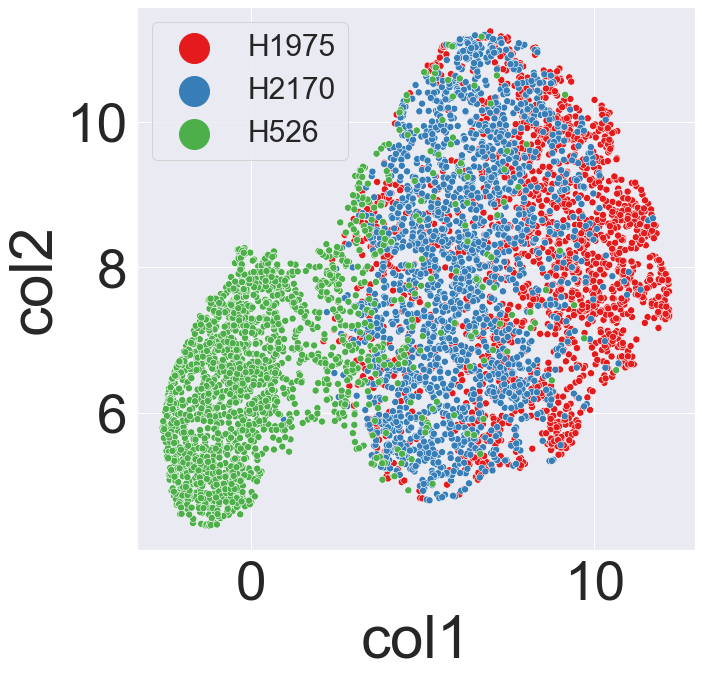

In [96]:
plt.figure(figsize=(10,10))
#plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=50, hue="ClassLabels1", palette=('Set1'))
plt.legend(markerscale=5, fontsize=30)